In [1]:
# Cell 1 — basic imports & device
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [3]:
import os
import numpy as np

SEED = 12345
DIGITS_TO_KEEP = [0, 4, 3]        # keep only these digits

# ---- Imbalance controls ----
N_PER_DIGIT_TOTAL = 400           # total samples per digit (wbflag=0 + wbflag=1)
FLAG1_RATIO = 0.30                # fraction of wbflag=1 (inverted) per digit (e.g., 0.2 -> 20%)

in_dir  = "datasets/MNIST/MNIST_subset"
out_dir = f"datasets/MNIST/MNIST_subset_{'_'.join(map(str, DIGITS_TO_KEEP))}_" \
          f"{len(DIGITS_TO_KEEP)*N_PER_DIGIT_TOTAL}_imb{int(FLAG1_RATIO*100)}"
os.makedirs(out_dir, exist_ok=True)

X_full = np.load(os.path.join(in_dir, "MNIST_train_wbX.npy"))     # (N,784) or (N,28,28)
digits = np.load(os.path.join(in_dir, "MNIST_train_digits.npy"))
wbflag = np.load(os.path.join(in_dir, "MNIST_train_wbflag.npy"))

rng = np.random.default_rng(SEED)
selected_indices = []

# precompute target counts per flag
target_n1 = int(round(N_PER_DIGIT_TOTAL * FLAG1_RATIO))     # wbflag=1
target_n0 = N_PER_DIGIT_TOTAL - target_n1                   # wbflag=0

for d in DIGITS_TO_KEEP:
    picks_for_d = []

    for f, target_n in [(0, target_n0), (1, target_n1)]:
        mask = (digits == d) & (wbflag == f)
        idxs = np.where(mask)[0]
        rng.shuffle(idxs)

        if len(idxs) < target_n:
            print(f"[WARN] digit={d}, wbflag={f}: requested {target_n}, "
                  f"but only {len(idxs)} available. Taking all available.")
        take = min(len(idxs), target_n)
        picks_for_d.extend(idxs[:take])

    # If one flag was short, optionally top-up from the other flag to still hit N_PER_DIGIT_TOTAL
    # Comment this block out if you prefer to keep the *exact* imbalance even when under-sampling occurs.
    if len(picks_for_d) < N_PER_DIGIT_TOTAL:
        need = N_PER_DIGIT_TOTAL - len(picks_for_d)
        # try topping up from whichever flag still has remaining samples
        for f in (0, 1):
            if need == 0: break
            mask = (digits == d) & (wbflag == f)
            pool = np.setdiff1d(np.where(mask)[0], np.array(picks_for_d), assume_unique=False)
            rng.shuffle(pool)
            extra = min(need, len(pool))
            if extra > 0:
                picks_for_d.extend(pool[:extra])
                need -= extra

    rng.shuffle(picks_for_d)
    selected_indices.extend(picks_for_d[:N_PER_DIGIT_TOTAL])  # enforce per-digit cap

selected_indices = np.array(selected_indices)
rng.shuffle(selected_indices)

digits_sub = digits[selected_indices]         # true digits, e.g., {0,3,4}
wbflag_sub = wbflag[selected_indices]         # sensitive flag {0 (orig), 1 (inverted)}
X_sub_full = X_full[selected_indices]         # images

# group = true digit (kept for analysis if needed)
group_sub = digits_sub.copy()

np.save(os.path.join(out_dir, "digits.npy"),  digits_sub)
np.save(os.path.join(out_dir, "wbflag.npy"),  wbflag_sub)
np.save(os.path.join(out_dir, "group.npy"),   group_sub)
np.save(os.path.join(out_dir, "indices.npy"), selected_indices)
np.save(os.path.join(out_dir, "wbX.npy"),     X_sub_full)

# Flatten if needed
if X_sub_full.ndim == 3:
    X_points = X_sub_full.reshape(X_sub_full.shape[0], -1).astype(np.float32)
else:
    X_points = X_sub_full.astype(np.float32)

# y_raw: original labels in DIGITS_TO_KEEP
y_raw = digits_sub.astype(np.int64)

# y: remap to {0,1,2} for CE if you ever need it
unique_labels = np.array(sorted(np.unique(y_raw)))  # e.g., [0,3,4]
label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
y = np.vectorize(label_to_idx.get)(y_raw).astype(np.int64)

np.save(os.path.join(out_dir, "X.npy"),      X_points)
np.save(os.path.join(out_dir, "y_raw.npy"),  y_raw)
np.save(os.path.join(out_dir, "y.npy"),      y)

# Quick counts
print(f"\nTarget per digit: wbflag=0 -> {target_n0}, wbflag=1 -> {target_n1} "
      f"(total {N_PER_DIGIT_TOTAL}, ratio flag1={FLAG1_RATIO:.2f})")

for d in DIGITS_TO_KEEP:
    for f in (0, 1):
        c = np.sum((digits_sub == d) & (wbflag_sub == f))
        print(f"(digit={d}, wbflag={f}): {c}")

print("\nRemapped classes (0,1,2):")
for k, lab in enumerate(unique_labels):
    print(f"class {k} (digit {lab}): {(y==k).sum()}")

print("\nShapes:")
print("X_points:", X_points.shape, "| y_raw:", y_raw.shape, "| y:", y.shape)



Target per digit: wbflag=0 -> 280, wbflag=1 -> 120 (total 400, ratio flag1=0.30)
(digit=0, wbflag=0): 280
(digit=0, wbflag=1): 120
(digit=4, wbflag=0): 280
(digit=4, wbflag=1): 120
(digit=3, wbflag=0): 280
(digit=3, wbflag=1): 120

Remapped classes (0,1,2):
class 0 (digit 0): 400
class 1 (digit 3): 400
class 2 (digit 4): 400

Shapes:
X_points: (1200, 784) | y_raw: (1200,) | y: (1200,)


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.set_device(device)

print(f"Using device: {device}")


Using device: cpu


In [7]:
def load_subset_with_wbflag(subset_dir, batch_size=256, shuffle=True):
    X = np.load(os.path.join(subset_dir, "X.npy")).astype(np.float32)     # (N, D)
    y = np.load(os.path.join(subset_dir, "y.npy")).astype(np.int64)       # (N,)
    S = np.load(os.path.join(subset_dir, "wbflag.npy")).astype(np.int64)  # (N,) 0=orig,1=inv
    assert len(X) == len(y) == len(S)

    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    S_t = torch.tensor(S, dtype=torch.long)

    ds = TensorDataset(X_t, y_t, S_t)   # returns (X, y, S)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
    input_dim = X.shape[1]
    return dl, input_dim, X, y, S

dataloader_wb, input_dim_from_loader, X_np, y_np, S_np = load_subset_with_wbflag(out_dir, batch_size=256, shuffle=True)
print("input_dim_from_loader:", input_dim_from_loader, "| dataset size:", len(X_np))


input_dim_from_loader: 784 | dataset size: 1200


In [9]:
class Autoencoder(nn.Module):
    """Plain AE: encoder -> decoder (no classifier head)."""
    def __init__(self, input_dim: int, latent_dim: int, negative_slope: float = 0.01):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 500),  nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 500),        nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 2000),       nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(2000, latent_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2000), nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(2000, 500),        nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, 500),         nn.LeakyReLU(negative_slope, inplace=True),
            nn.Linear(500, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [11]:
def pretrain_autoencoder(dataloader, input_dim, latent_dim, device, epochs=30, lr=1e-3):
    ae = Autoencoder(input_dim, latent_dim).to(device)
    opt = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(epochs):
        total = 0
        nobs = 0
        for batch in dataloader:
            if isinstance(batch, (list, tuple)):
                xb = batch[0]
            else:
                xb = batch
            xb = xb.to(device).float()

            opt.zero_grad(set_to_none=True)
            x_hat, _ = ae(xb)
            loss = loss_fn(x_hat, xb)
            loss.backward()
            opt.step()

            bs = xb.size(0)
            total += loss.item() * bs
            nobs  += bs
        print(f"Pretrain epoch {ep+1}/{epochs} | loss={total/nobs:.6f}")
    return ae


In [13]:
@torch.no_grad()
def init_kmeans_centers_from_latent(ae, dataloader, device, k: int):
    """Run KMeans on current latent to initialize centers."""
    ae.eval()
    Z = []
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)
        Z.append(z.cpu())
    Z = torch.cat(Z, dim=0).numpy()
    km = KMeans(n_clusters=k, n_init=3, random_state=0).fit(Z)
    centers = torch.tensor(km.cluster_centers_, dtype=torch.float32, device=device, requires_grad=True)
    return torch.nn.Parameter(centers)

In [15]:
@torch.no_grad()
def torch_kmeans_cost_full(ae, centers, dataloader, device):
    """(1/N) * sum_i min_j ||z_i - mu_j||^2 on the whole dataset (for reporting)."""
    ae.eval()
    Z = []
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)
        Z.append(z)
    Z = torch.cat(Z, dim=0)
    d2 = torch.cdist(Z, centers).pow(2)
    return d2.min(dim=1).values.mean().item()

In [17]:

@torch.no_grad()
def torch_kmeans_cost_full_stream(ae, centers, dataloader, device, reduce: str = "mean"):

    ae.eval()
    centers = centers.to(device)

    total, nobs = 0.0, 0
    for batch in dataloader:
        xb = batch[0] if isinstance(batch, (list, tuple)) else batch
        xb = xb.to(device).float()
        _, z = ae(xb)                           # [B, D]
        d2 = torch.cdist(z, centers).pow(2)     # [B, K]
        mins = d2.min(dim=1).values             # [B,]

        if reduce == "sum":
            total += mins.sum().item()
        else:  # 'mean' -> θα επιστρέψουμε global mean
            total += mins.sum().item()
            nobs  += mins.numel()

    if reduce == "sum":
        return total
    else:
        loss = total / max(1, nobs)
        return loss


In [19]:
@torch.enable_grad()
def social_fair_dataset(ae, centers, dataloader, device, eps=1e-12):
    """
    Social Fair objective (dataset-level; hard partition):
      Φ_social = max{ Δ(C, U∩A)/|A|,  Δ(C, U∩B)/|B| },
    where Δ(C, U∩A) = sum_j sum_{x∈U_j∩A} ||z - c_j||^2.
    Returns: scalar with grad + (muA, muB) for logging.
    """
    ae.train()
    sumA = torch.zeros((), device=device)
    sumB = torch.zeros((), device=device)
    nA = 0
    nB = 0

    for batch in dataloader:
        xb = batch[0].to(device).float()
        S  = batch[-1].to(device).long()

        x_hat, z = ae(xb)

        # hard assignments: a_i = argmin_j ||z-c_j||^2
        d2 = torch.cdist(z, centers).pow(2)     # (B,K)
        a  = d2.argmin(dim=1)                   # (B,)
        d2_assigned = (z - centers[a]).pow(2).sum(dim=1)  # (B,)

        A = (S == 1)
        B = ~A
        if A.any():
            sumA = sumA + d2_assigned[A].sum()
            nA  += int(A.sum().item())
        if B.any():
            sumB = sumB + d2_assigned[B].sum()
            nB  += int(B.sum().item())

    muA = sumA / (nA + eps) if nA > 0 else torch.zeros((), device=device)
    muB = sumB / (nB + eps) if nB > 0 else torch.zeros((), device=device)
    social = torch.maximum(muA, muB)  # hard max
    return social, muA, muB

In [21]:
@torch.enable_grad()
def separation_fair_dataset(ae, centers, dataloader, device, eps=1e-12):
    """
    Separation Fair objective (dataset-level):
      Φ_sep = min{ E_A[d^2_bisector], E_B[d^2_bisector] },
    where d^2_bisector is squared distance of z to the bisector between its
    nearest and 2nd-nearest centers.
    Returns: scalar with grad + (muA, muB) for logging.
    """
    ae.train()
    sumA = torch.zeros((), device=device)
    sumB = torch.zeros((), device=device)
    nA = 0
    nB = 0

    for batch in dataloader:
        xb = batch[0].to(device).float()
        S  = batch[-1].to(device).long()

        x_hat, z = ae(xb)

        d2 = torch.cdist(z, centers).pow(2)          # (B,K)
        m1_idx = d2.argmin(dim=1)
        d2_mask = d2.scatter(1, m1_idx.unsqueeze(1), float('inf'))
        m2_idx = d2_mask.argmin(dim=1)

        m1 = centers[m1_idx]
        m2 = centers[m2_idx]
        m  = 0.5 * (m1 + m2)
        v  = m2 - m1
        vn = torch.clamp(torch.linalg.norm(v, dim=1, keepdim=True), min=1e-12)
        vhat = v / vn
        s  = ((z - m) * vhat).sum(dim=1)             # signed distance to bisector
        d2_hp = s * s

        A = (S == 1)
        B = ~A
        if A.any():
            sumA = sumA + d2_hp[A].sum()
            nA  += int(A.sum().item())
        if B.any():
            sumB = sumB + d2_hp[B].sum()
            nB  += int(B.sum().item())

    muA = sumA / (nA + eps) if nA > 0 else torch.zeros((), device=device)
    muB = sumB / (nB + eps) if nB > 0 else torch.zeros((), device=device)
    sep = torch.minimum(muA, muB)  # hard min
    return sep, muA, muB

In [23]:
def train_deepclust_social(
    ae, dataloader, device, input_dim, latent_dim, k=3,
    epochs=50, lr=1e-3,
    alpha=0.1,        # recon weight
    beta=1.0,         # compactness weight (hard k-means)
    gamma_social=1.0, # social fairness (minimize larger group cost)
    clip_grad=5.0,
    report_reduce="sum"
):
    """
    Per-epoch:
      Phase 1 (mini-batch): optimize α*MSE + β*compactness
      Phase 2 (full dataset): optimize γ_social*Social  - γ_sep*Separation
    Returns the trained AE, the learnable centers, and a history dict.
    """
    ae = ae.to(device)
    mse = nn.MSELoss()

    # (a) init centers from current latent
    centers = init_kmeans_centers_from_latent(ae, dataloader, device, k)
    centers.requires_grad_(True)

    #copy of unfair centers
    centers_unfair = centers.detach().clone()    
    # (b) optimizer (AE + centers)
    opt = optim.AdamW(
        [{"params": ae.parameters(), "lr": lr},
         {"params": [centers],       "lr": lr * 0.3}],
        weight_decay=1e-4
    )

    history = {
        "total": [], "rec": [], "cmp": [],
        "social": [], "sep": [],
        "muA_social": [], "muB_social": [],
        "muA_sep": [],    "muB_sep": []
    }
    for ep in range(epochs):
        # ---------- Phase 1: per-batch recon + compactness ----------
        ae.train()
        tot = rec_tot = cmp_tot = 0.0
        nobs = 0

        for batch in dataloader:
            xb = batch[0].to(device).float()

            x_hat, z = ae(xb)

            # reconstruction (input space)
            rec_loss = mse(x_hat, xb)

            # compactness (hard k-means on latent)
            d2 = torch.cdist(z, centers).pow(2)
            min_d2 = d2.min(dim=1).values
            cmp_loss = min_d2.mean()

            loss_phase1 = alpha * rec_loss + beta * cmp_loss

            opt.zero_grad(set_to_none=True)
            loss_phase1.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
            opt.step()

            bs = xb.size(0)
            nobs    += bs
            rec_tot += rec_loss.item() * bs
            cmp_tot += cmp_loss.item() * bs
            tot     += loss_phase1.item() * bs

        rec_epoch = rec_tot / nobs
        cmp_epoch = cmp_tot / nobs
        total_epoch = tot / nobs

        # ---------- Phase 2: FULL-dataset fairness step ----------
        opt.zero_grad(set_to_none=True)

        social_term, muA_soc, muB_soc = social_fair_dataset(ae, centers, dataloader, device)
        sep_term,    muA_sep, muB_sep = separation_fair_dataset(ae, centers, dataloader, device)

        # NOTE: Social is minimized; Separation is maximized -> subtract sep
        fairness_loss = gamma_social * social_term #- gamma_sep * sep_term
        fairness_loss.backward()
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(ae.parameters(), clip_grad)
        opt.step()


        
        # ---------- logging ----------
        history["total"].append(total_epoch + fairness_loss.item())
        history["rec"].append(rec_epoch)
        history["cmp"].append(cmp_epoch)
        history["social"].append(social_term.item())
        history["sep"].append(sep_term.item())
        history["muA_social"].append(muA_soc.item())
        history["muB_social"].append(muB_soc.item())
        history["muA_sep"].append(muA_sep.item())
        history["muB_sep"].append(muB_sep.item())
        

        print(f"[{ep+1:02d}/{epochs}] "
              f"Rec={rec_epoch:.5f} | Cmp={cmp_epoch:.5f} | "
              f"Social(max)={social_term.item():.5f} | Sep(min)={sep_term.item():.5f} | "
              f"μA_social={muA_soc.item():.5f} μB_social={muB_soc.item():.5f} | "
              f"μA_seperation={muA_sep.item():.5f} μB_seperation={muB_sep.item():.5f}")

    return ae, centers, history

In [25]:
# === Patch the grid runner to collect decoded centers (L, S, K, D) ===
import numpy as np
import torch, copy
from pathlib import Path

def run_lambda_seed_grid(
    ae_pretrained,              # pretrained AE (weights used as reset point)
    dataloader_wb,              # must return (X, y, S)
    device,
    latent_dim=20,
    k=3,
    epochs=50,
    lr=1e-3,
    alpha=0.1,
    beta=0.1,
    lambda_list=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
    seeds=range(1),
    save_dir="centroids_deep",
    save_centers_files=True,
    collect_decoded_centers=True,  
):
    min_fair_dict = {lam: [] for lam in lambda_list}
    max_fair_dict = {lam: [] for lam in lambda_list}
    seperation_fairness_gaps  = {lam: [] for lam in lambda_list}
    social_fairness_gaps  = {lam: [] for lam in lambda_list}
    kmeans_costs   = {lam: [] for lam in lambda_list}
    recon_costs    = {lam: [] for lam in lambda_list}
    compact_costs  = {lam: [] for lam in lambda_list}
    

    first_batch = next(iter(dataloader_wb))
    X_first = first_batch[0] if isinstance(first_batch, (list, tuple)) else first_batch
    D = X_first.shape[1]

    decoded_centers = None
    if collect_decoded_centers:
        L = len(lambda_list); S = len(list(seeds))
        decoded_centers = np.zeros((L, S, k, D), dtype=np.float32)

    pretrained_state = copy.deepcopy(ae_pretrained.state_dict())

    for li, lam in enumerate(lambda_list):
        print(f"\n=== λ (gamma) = {lam} ===")
        for si, seed in enumerate(seeds):
            print(f"  -> seed {seed}")
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

            ae = copy.deepcopy(ae_pretrained).to(device)
            ae.load_state_dict(pretrained_state)

            ae, centers, history = train_deepclust_social(
                ae, dataloader_wb, device,input_dim=input_dim, 
                latent_dim=latent_dim, k=k,
                lr=lr, epochs=epochs,
                alpha=alpha, beta=beta, gamma_social=lam,report_reduce="sum"
            )
    
            kmeans_cost = torch_kmeans_cost_full_stream(ae, centers, dataloader_wb, device,reduce="sum")
            minFair,cfdA, cfdB = separation_fair_dataset(ae, centers, dataloader_wb, device, eps=1e-12)
            maxFair,muA,muB= social_fair_dataset(ae, centers, dataloader_wb, device, eps=1e-12)
            seperation_gap = abs(cfdA - cfdB)
            social_gap = abs(muA - muB)

            kmeans_costs[lam].append(kmeans_cost)
            min_fair_dict[lam].append(minFair)
            max_fair_dict[lam].append(maxFair)
            seperation_fairness_gaps[lam].append(seperation_gap)
            social_fairness_gaps[lam].append(social_gap)
            recon_costs[lam].append(history["rec"][-1])
            compact_costs[lam].append(history["cmp"][-1])           
    results = {
        "min_fair": min_fair_dict,
        "max_fair": max_fair_dict,
        "seperation_fair_gap": seperation_fairness_gaps,
        "social_fair_gap": social_fairness_gaps,
        "kmeans": kmeans_costs,
        "rec": recon_costs,
        "cmp": compact_costs,
        
    }
    # Return decoded centers alongside results
    return results, list(lambda_list)


In [27]:
first_batch = next(iter(dataloader_wb))
X0 = first_batch[0] if isinstance(first_batch, (list, tuple)) else first_batch
input_dim = X0.shape[1]
latent_dim = 20
k = 3
ae = pretrain_autoencoder(dataloader_wb, input_dim, latent_dim=20, device=device, epochs=50)
results, lambda2_list = run_lambda_seed_grid(
    ae_pretrained=ae,              # your pretrained AE
    dataloader_wb=dataloader_wb,   # (X, y, S)
    device=device,
    latent_dim=20,
    k=3,
    epochs=50,
    lr=0.001,
    alpha=1.0,
    beta=1.0,
    lambda_list=[0.0,0.2,0.4,0.6,0.8,1.0],
    seeds=range(10),
    save_dir="centroids_deep_v1",
    save_centers_files=True,
    collect_decoded_centers=True,
)




Pretrain epoch 1/50 | loss=0.264729
Pretrain epoch 2/50 | loss=0.113398
Pretrain epoch 3/50 | loss=0.099191
Pretrain epoch 4/50 | loss=0.077991
Pretrain epoch 5/50 | loss=0.072613
Pretrain epoch 6/50 | loss=0.070959
Pretrain epoch 7/50 | loss=0.069306
Pretrain epoch 8/50 | loss=0.068261
Pretrain epoch 9/50 | loss=0.067218
Pretrain epoch 10/50 | loss=0.066320
Pretrain epoch 11/50 | loss=0.065628
Pretrain epoch 12/50 | loss=0.065133
Pretrain epoch 13/50 | loss=0.064661
Pretrain epoch 14/50 | loss=0.064119
Pretrain epoch 15/50 | loss=0.063475
Pretrain epoch 16/50 | loss=0.062902
Pretrain epoch 17/50 | loss=0.062180
Pretrain epoch 18/50 | loss=0.061566
Pretrain epoch 19/50 | loss=0.060579
Pretrain epoch 20/50 | loss=0.059674
Pretrain epoch 21/50 | loss=0.058727
Pretrain epoch 22/50 | loss=0.058666
Pretrain epoch 23/50 | loss=0.058122
Pretrain epoch 24/50 | loss=0.057055
Pretrain epoch 25/50 | loss=0.055837
Pretrain epoch 26/50 | loss=0.054832
Pretrain epoch 27/50 | loss=0.054144
Pretrain e

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09722 | Cmp=0.95795 | Social(max)=0.27189 | Sep(min)=0.96913 | μA_social=0.16002 μB_social=0.27189 | μA_seperation=4.51959 μB_seperation=0.96913
[02/50] Rec=0.09612 | Cmp=0.21974 | Social(max)=0.14605 | Sep(min)=1.28727 | μA_social=0.10980 μB_social=0.14605 | μA_seperation=4.42169 μB_seperation=1.28727
[03/50] Rec=0.07217 | Cmp=0.10920 | Social(max)=0.09133 | Sep(min)=1.29968 | μA_social=0.04892 μB_social=0.09133 | μA_seperation=3.80003 μB_seperation=1.29968
[04/50] Rec=0.06961 | Cmp=0.06618 | Social(max)=0.06646 | Sep(min)=1.39765 | μA_social=0.01961 μB_social=0.06646 | μA_seperation=4.17126 μB_seperation=1.39765
[05/50] Rec=0.06735 | Cmp=0.04748 | Social(max)=0.05308 | Sep(min)=1.35283 | μA_social=0.00942 μB_social=0.05308 | μA_seperation=4.03573 μB_seperation=1.35283
[06/50] Rec=0.06698 | Cmp=0.04320 | Social(max)=0.03514 | Sep(min)=1.38258 | μA_social=0.00715 μB_social=0.03514 | μA_seperation=4.01877 μB_seperation=1.38258
[07/50] Rec=0.06735 | Cmp=0.04006 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10089 | Cmp=1.05698 | Social(max)=0.24733 | Sep(min)=0.97844 | μA_social=0.19995 μB_social=0.24733 | μA_seperation=4.11459 μB_seperation=0.97844
[02/50] Rec=0.09354 | Cmp=0.18710 | Social(max)=0.13852 | Sep(min)=1.31256 | μA_social=0.09622 μB_social=0.13852 | μA_seperation=4.18610 μB_seperation=1.31256
[03/50] Rec=0.07247 | Cmp=0.10473 | Social(max)=0.09069 | Sep(min)=1.20576 | μA_social=0.05557 μB_social=0.09069 | μA_seperation=3.89719 μB_seperation=1.20576
[04/50] Rec=0.06714 | Cmp=0.07642 | Social(max)=0.06663 | Sep(min)=1.40821 | μA_social=0.03859 μB_social=0.06663 | μA_seperation=4.49998 μB_seperation=1.40821
[05/50] Rec=0.06647 | Cmp=0.05141 | Social(max)=0.05654 | Sep(min)=1.40259 | μA_social=0.01817 μB_social=0.05654 | μA_seperation=4.07837 μB_seperation=1.40259
[06/50] Rec=0.06660 | Cmp=0.04181 | Social(max)=0.03423 | Sep(min)=1.32144 | μA_social=0.00857 μB_social=0.03423 | μA_seperation=4.13764 μB_seperation=1.32144
[07/50] Rec=0.06676 | Cmp=0.03146 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09267 | Cmp=1.01170 | Social(max)=0.28631 | Sep(min)=1.15429 | μA_social=0.28631 μB_social=0.24060 | μA_seperation=4.23791 μB_seperation=1.15429
[02/50] Rec=0.08302 | Cmp=0.20095 | Social(max)=0.14516 | Sep(min)=1.18979 | μA_social=0.11854 μB_social=0.14516 | μA_seperation=4.41007 μB_seperation=1.18979
[03/50] Rec=0.07253 | Cmp=0.10920 | Social(max)=0.10518 | Sep(min)=1.25080 | μA_social=0.05742 μB_social=0.10518 | μA_seperation=4.16275 μB_seperation=1.25080
[04/50] Rec=0.06795 | Cmp=0.09713 | Social(max)=0.08031 | Sep(min)=1.31374 | μA_social=0.02261 μB_social=0.08031 | μA_seperation=4.18425 μB_seperation=1.31374
[05/50] Rec=0.06679 | Cmp=0.06703 | Social(max)=0.07380 | Sep(min)=1.18058 | μA_social=0.01072 μB_social=0.07380 | μA_seperation=4.31473 μB_seperation=1.18058
[06/50] Rec=0.06629 | Cmp=0.04754 | Social(max)=0.05234 | Sep(min)=1.25862 | μA_social=0.00659 μB_social=0.05234 | μA_seperation=4.23533 μB_seperation=1.25862
[07/50] Rec=0.06537 | Cmp=0.03602 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09538 | Cmp=1.10490 | Social(max)=0.53831 | Sep(min)=1.04387 | μA_social=0.53831 μB_social=0.25012 | μA_seperation=3.73475 μB_seperation=1.04387
[02/50] Rec=0.07731 | Cmp=0.23108 | Social(max)=0.15978 | Sep(min)=1.33616 | μA_social=0.15978 μB_social=0.14070 | μA_seperation=4.19567 μB_seperation=1.33616
[03/50] Rec=0.07023 | Cmp=0.11250 | Social(max)=0.09210 | Sep(min)=1.29870 | μA_social=0.03484 μB_social=0.09210 | μA_seperation=4.06045 μB_seperation=1.29870
[04/50] Rec=0.06783 | Cmp=0.07696 | Social(max)=0.07705 | Sep(min)=1.45433 | μA_social=0.01442 μB_social=0.07705 | μA_seperation=4.11944 μB_seperation=1.45433
[05/50] Rec=0.06745 | Cmp=0.06275 | Social(max)=0.05533 | Sep(min)=1.23710 | μA_social=0.00669 μB_social=0.05533 | μA_seperation=4.04020 μB_seperation=1.23710
[06/50] Rec=0.06590 | Cmp=0.04065 | Social(max)=0.04918 | Sep(min)=1.22790 | μA_social=0.00457 μB_social=0.04918 | μA_seperation=4.18684 μB_seperation=1.22790
[07/50] Rec=0.06614 | Cmp=0.02833 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09905 | Cmp=0.98241 | Social(max)=0.27809 | Sep(min)=0.98654 | μA_social=0.27809 μB_social=0.23905 | μA_seperation=4.53098 μB_seperation=0.98654
[02/50] Rec=0.09146 | Cmp=0.19791 | Social(max)=0.14238 | Sep(min)=1.39683 | μA_social=0.07671 μB_social=0.14238 | μA_seperation=4.05237 μB_seperation=1.39683
[03/50] Rec=0.07113 | Cmp=0.11133 | Social(max)=0.09273 | Sep(min)=1.29444 | μA_social=0.04695 μB_social=0.09273 | μA_seperation=3.73767 μB_seperation=1.29444
[04/50] Rec=0.06789 | Cmp=0.08067 | Social(max)=0.06647 | Sep(min)=1.32987 | μA_social=0.02362 μB_social=0.06647 | μA_seperation=4.12978 μB_seperation=1.32987
[05/50] Rec=0.06676 | Cmp=0.05342 | Social(max)=0.04929 | Sep(min)=1.25103 | μA_social=0.01791 μB_social=0.04929 | μA_seperation=4.24693 μB_seperation=1.25103
[06/50] Rec=0.06567 | Cmp=0.03624 | Social(max)=0.03994 | Sep(min)=1.18439 | μA_social=0.00913 μB_social=0.03994 | μA_seperation=4.21976 μB_seperation=1.18439
[07/50] Rec=0.06598 | Cmp=0.02504 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10310 | Cmp=1.06277 | Social(max)=0.25340 | Sep(min)=0.97775 | μA_social=0.20771 μB_social=0.25340 | μA_seperation=4.08749 μB_seperation=0.97775
[02/50] Rec=0.08913 | Cmp=0.20816 | Social(max)=0.17006 | Sep(min)=1.42496 | μA_social=0.17006 μB_social=0.13240 | μA_seperation=4.32805 μB_seperation=1.42496
[03/50] Rec=0.07186 | Cmp=0.11320 | Social(max)=0.08622 | Sep(min)=1.28354 | μA_social=0.08187 μB_social=0.08622 | μA_seperation=3.99837 μB_seperation=1.28354
[04/50] Rec=0.06799 | Cmp=0.08632 | Social(max)=0.06491 | Sep(min)=1.38135 | μA_social=0.03050 μB_social=0.06491 | μA_seperation=3.96176 μB_seperation=1.38135
[05/50] Rec=0.06726 | Cmp=0.05665 | Social(max)=0.04574 | Sep(min)=1.25858 | μA_social=0.01592 μB_social=0.04574 | μA_seperation=4.16579 μB_seperation=1.25858
[06/50] Rec=0.06621 | Cmp=0.03270 | Social(max)=0.03745 | Sep(min)=1.19905 | μA_social=0.00839 μB_social=0.03745 | μA_seperation=4.21369 μB_seperation=1.19905
[07/50] Rec=0.06600 | Cmp=0.02450 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10284 | Cmp=1.01464 | Social(max)=0.27427 | Sep(min)=1.17015 | μA_social=0.21444 μB_social=0.27427 | μA_seperation=4.81219 μB_seperation=1.17015
[02/50] Rec=0.09433 | Cmp=0.25337 | Social(max)=0.21427 | Sep(min)=1.15228 | μA_social=0.21427 μB_social=0.16712 | μA_seperation=4.48818 μB_seperation=1.15228
[03/50] Rec=0.07263 | Cmp=0.13986 | Social(max)=0.10391 | Sep(min)=1.34998 | μA_social=0.08380 μB_social=0.10391 | μA_seperation=4.76195 μB_seperation=1.34998
[04/50] Rec=0.07013 | Cmp=0.07981 | Social(max)=0.07898 | Sep(min)=1.24004 | μA_social=0.02691 μB_social=0.07898 | μA_seperation=4.32299 μB_seperation=1.24004
[05/50] Rec=0.06701 | Cmp=0.05942 | Social(max)=0.06025 | Sep(min)=1.28235 | μA_social=0.01129 μB_social=0.06025 | μA_seperation=4.34734 μB_seperation=1.28235
[06/50] Rec=0.06575 | Cmp=0.04391 | Social(max)=0.05588 | Sep(min)=1.16513 | μA_social=0.00621 μB_social=0.05588 | μA_seperation=4.44763 μB_seperation=1.16513
[07/50] Rec=0.06535 | Cmp=0.03483 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09784 | Cmp=0.97804 | Social(max)=0.24518 | Sep(min)=0.95756 | μA_social=0.23165 μB_social=0.24518 | μA_seperation=4.43227 μB_seperation=0.95756
[02/50] Rec=0.09100 | Cmp=0.20052 | Social(max)=0.13758 | Sep(min)=1.38110 | μA_social=0.10904 μB_social=0.13758 | μA_seperation=4.27428 μB_seperation=1.38110
[03/50] Rec=0.07042 | Cmp=0.11309 | Social(max)=0.08966 | Sep(min)=1.29517 | μA_social=0.06327 μB_social=0.08966 | μA_seperation=3.67538 μB_seperation=1.29517
[04/50] Rec=0.06805 | Cmp=0.07948 | Social(max)=0.06576 | Sep(min)=1.37429 | μA_social=0.02799 μB_social=0.06576 | μA_seperation=4.41061 μB_seperation=1.37429
[05/50] Rec=0.06685 | Cmp=0.05542 | Social(max)=0.06240 | Sep(min)=1.42191 | μA_social=0.02102 μB_social=0.06240 | μA_seperation=4.26581 μB_seperation=1.42191
[06/50] Rec=0.06633 | Cmp=0.04637 | Social(max)=0.03652 | Sep(min)=1.37030 | μA_social=0.01308 μB_social=0.03652 | μA_seperation=4.08895 μB_seperation=1.37030
[07/50] Rec=0.06675 | Cmp=0.03911 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10324 | Cmp=1.06022 | Social(max)=0.27242 | Sep(min)=0.96053 | μA_social=0.23575 μB_social=0.27242 | μA_seperation=3.78489 μB_seperation=0.96053
[02/50] Rec=0.08512 | Cmp=0.21226 | Social(max)=0.15119 | Sep(min)=1.35890 | μA_social=0.14286 μB_social=0.15119 | μA_seperation=4.41163 μB_seperation=1.35890
[03/50] Rec=0.07402 | Cmp=0.11757 | Social(max)=0.10302 | Sep(min)=1.31561 | μA_social=0.06851 μB_social=0.10302 | μA_seperation=3.87385 μB_seperation=1.31561
[04/50] Rec=0.06826 | Cmp=0.07819 | Social(max)=0.07168 | Sep(min)=1.19235 | μA_social=0.02841 μB_social=0.07168 | μA_seperation=4.09623 μB_seperation=1.19235
[05/50] Rec=0.06723 | Cmp=0.05099 | Social(max)=0.04442 | Sep(min)=1.31896 | μA_social=0.00942 μB_social=0.04442 | μA_seperation=4.16294 μB_seperation=1.31896
[06/50] Rec=0.06667 | Cmp=0.03297 | Social(max)=0.03267 | Sep(min)=1.33507 | μA_social=0.00480 μB_social=0.03267 | μA_seperation=4.17018 μB_seperation=1.33507
[07/50] Rec=0.06642 | Cmp=0.02331 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09818 | Cmp=1.13519 | Social(max)=0.38744 | Sep(min)=1.02520 | μA_social=0.38744 μB_social=0.24501 | μA_seperation=3.04662 μB_seperation=1.02520
[02/50] Rec=0.08118 | Cmp=0.18773 | Social(max)=0.14117 | Sep(min)=1.37464 | μA_social=0.09996 μB_social=0.14117 | μA_seperation=4.55486 μB_seperation=1.37464
[03/50] Rec=0.07455 | Cmp=0.10988 | Social(max)=0.09012 | Sep(min)=1.33464 | μA_social=0.04218 μB_social=0.09012 | μA_seperation=4.13221 μB_seperation=1.33464
[04/50] Rec=0.07002 | Cmp=0.07122 | Social(max)=0.06660 | Sep(min)=1.27673 | μA_social=0.02202 μB_social=0.06660 | μA_seperation=4.16024 μB_seperation=1.27673
[05/50] Rec=0.06658 | Cmp=0.04722 | Social(max)=0.05093 | Sep(min)=1.19437 | μA_social=0.01069 μB_social=0.05093 | μA_seperation=4.13030 μB_seperation=1.19437
[06/50] Rec=0.06621 | Cmp=0.03287 | Social(max)=0.03782 | Sep(min)=1.18421 | μA_social=0.00577 μB_social=0.03782 | μA_seperation=4.20988 μB_seperation=1.18421
[07/50] Rec=0.06582 | Cmp=0.02399 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09722 | Cmp=0.95795 | Social(max)=0.27189 | Sep(min)=0.96913 | μA_social=0.16002 μB_social=0.27189 | μA_seperation=4.51959 μB_seperation=0.96913
[02/50] Rec=0.09620 | Cmp=0.21205 | Social(max)=0.14165 | Sep(min)=1.29940 | μA_social=0.10904 μB_social=0.14165 | μA_seperation=4.42325 μB_seperation=1.29940
[03/50] Rec=0.07223 | Cmp=0.10416 | Social(max)=0.08635 | Sep(min)=1.28828 | μA_social=0.04887 μB_social=0.08635 | μA_seperation=3.81310 μB_seperation=1.28828
[04/50] Rec=0.06950 | Cmp=0.06182 | Social(max)=0.06288 | Sep(min)=1.40259 | μA_social=0.01688 μB_social=0.06288 | μA_seperation=4.16531 μB_seperation=1.40259
[05/50] Rec=0.06711 | Cmp=0.04034 | Social(max)=0.04059 | Sep(min)=1.34996 | μA_social=0.00738 μB_social=0.04059 | μA_seperation=4.03596 μB_seperation=1.34996
[06/50] Rec=0.06665 | Cmp=0.02489 | Social(max)=0.02436 | Sep(min)=1.26806 | μA_social=0.00444 μB_social=0.02436 | μA_seperation=4.09442 μB_seperation=1.26806
[07/50] Rec=0.06617 | Cmp=0.01606 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10089 | Cmp=1.05698 | Social(max)=0.24733 | Sep(min)=0.97844 | μA_social=0.19995 μB_social=0.24733 | μA_seperation=4.11459 μB_seperation=0.97844
[02/50] Rec=0.09359 | Cmp=0.18265 | Social(max)=0.13582 | Sep(min)=1.30195 | μA_social=0.09583 μB_social=0.13582 | μA_seperation=4.18632 μB_seperation=1.30195
[03/50] Rec=0.07252 | Cmp=0.10069 | Social(max)=0.08809 | Sep(min)=1.20516 | μA_social=0.05588 μB_social=0.08809 | μA_seperation=3.90167 μB_seperation=1.20516
[04/50] Rec=0.06704 | Cmp=0.07325 | Social(max)=0.06220 | Sep(min)=1.39153 | μA_social=0.03876 μB_social=0.06220 | μA_seperation=4.49751 μB_seperation=1.39153
[05/50] Rec=0.06634 | Cmp=0.04752 | Social(max)=0.04774 | Sep(min)=1.39695 | μA_social=0.01854 μB_social=0.04774 | μA_seperation=4.06269 μB_seperation=1.39695
[06/50] Rec=0.06621 | Cmp=0.03093 | Social(max)=0.03001 | Sep(min)=1.32664 | μA_social=0.00892 μB_social=0.03001 | μA_seperation=4.13245 μB_seperation=1.32664
[07/50] Rec=0.06608 | Cmp=0.01959 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09267 | Cmp=1.01170 | Social(max)=0.28631 | Sep(min)=1.15429 | μA_social=0.28631 μB_social=0.24060 | μA_seperation=4.23791 μB_seperation=1.15429
[02/50] Rec=0.08427 | Cmp=0.18233 | Social(max)=0.14496 | Sep(min)=1.18940 | μA_social=0.07789 μB_social=0.14496 | μA_seperation=4.65691 μB_seperation=1.18940
[03/50] Rec=0.07298 | Cmp=0.10631 | Social(max)=0.10508 | Sep(min)=1.23609 | μA_social=0.05381 μB_social=0.10508 | μA_seperation=4.12615 μB_seperation=1.23609
[04/50] Rec=0.06871 | Cmp=0.08592 | Social(max)=0.07858 | Sep(min)=1.34815 | μA_social=0.02711 μB_social=0.07858 | μA_seperation=4.36655 μB_seperation=1.34815
[05/50] Rec=0.06756 | Cmp=0.06365 | Social(max)=0.06173 | Sep(min)=1.22606 | μA_social=0.01516 μB_social=0.06173 | μA_seperation=4.16583 μB_seperation=1.22606
[06/50] Rec=0.06645 | Cmp=0.04377 | Social(max)=0.04747 | Sep(min)=1.21284 | μA_social=0.00869 μB_social=0.04747 | μA_seperation=4.37815 μB_seperation=1.21284
[07/50] Rec=0.06543 | Cmp=0.03195 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09538 | Cmp=1.10490 | Social(max)=0.53831 | Sep(min)=1.04387 | μA_social=0.53831 μB_social=0.25012 | μA_seperation=3.73475 μB_seperation=1.04387
[02/50] Rec=0.07962 | Cmp=0.19703 | Social(max)=0.14018 | Sep(min)=1.35827 | μA_social=0.08631 μB_social=0.14018 | μA_seperation=4.33991 μB_seperation=1.35827
[03/50] Rec=0.07205 | Cmp=0.09935 | Social(max)=0.09162 | Sep(min)=1.28420 | μA_social=0.03770 μB_social=0.09162 | μA_seperation=3.99424 μB_seperation=1.28420
[04/50] Rec=0.06854 | Cmp=0.07075 | Social(max)=0.07676 | Sep(min)=1.47622 | μA_social=0.01890 μB_social=0.07676 | μA_seperation=4.18469 μB_seperation=1.47622
[05/50] Rec=0.06701 | Cmp=0.05573 | Social(max)=0.05256 | Sep(min)=1.29266 | μA_social=0.00808 μB_social=0.05256 | μA_seperation=4.07808 μB_seperation=1.29266
[06/50] Rec=0.06607 | Cmp=0.03929 | Social(max)=0.03976 | Sep(min)=1.24468 | μA_social=0.00590 μB_social=0.03976 | μA_seperation=4.19404 μB_seperation=1.24468
[07/50] Rec=0.06593 | Cmp=0.02485 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09905 | Cmp=0.98241 | Social(max)=0.27809 | Sep(min)=0.98654 | μA_social=0.27809 μB_social=0.23905 | μA_seperation=4.53098 μB_seperation=0.98654
[02/50] Rec=0.09036 | Cmp=0.18003 | Social(max)=0.14301 | Sep(min)=1.40229 | μA_social=0.05015 μB_social=0.14301 | μA_seperation=4.35366 μB_seperation=1.40229
[03/50] Rec=0.07086 | Cmp=0.10986 | Social(max)=0.09115 | Sep(min)=1.29435 | μA_social=0.04009 μB_social=0.09115 | μA_seperation=3.76751 μB_seperation=1.29435
[04/50] Rec=0.06799 | Cmp=0.07626 | Social(max)=0.06731 | Sep(min)=1.39948 | μA_social=0.02191 μB_social=0.06731 | μA_seperation=4.18340 μB_seperation=1.39948
[05/50] Rec=0.06758 | Cmp=0.05339 | Social(max)=0.04589 | Sep(min)=1.30138 | μA_social=0.01319 μB_social=0.04589 | μA_seperation=4.08929 μB_seperation=1.30138
[06/50] Rec=0.06580 | Cmp=0.03803 | Social(max)=0.04077 | Sep(min)=1.15993 | μA_social=0.00882 μB_social=0.04077 | μA_seperation=4.22256 μB_seperation=1.15993
[07/50] Rec=0.06615 | Cmp=0.02488 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10310 | Cmp=1.06277 | Social(max)=0.25340 | Sep(min)=0.97775 | μA_social=0.20771 μB_social=0.25340 | μA_seperation=4.08749 μB_seperation=0.97775
[02/50] Rec=0.08920 | Cmp=0.20376 | Social(max)=0.17023 | Sep(min)=1.41281 | μA_social=0.17023 μB_social=0.12928 | μA_seperation=4.32856 μB_seperation=1.41281
[03/50] Rec=0.07188 | Cmp=0.10234 | Social(max)=0.08489 | Sep(min)=1.30251 | μA_social=0.06808 μB_social=0.08489 | μA_seperation=3.97575 μB_seperation=1.30251
[04/50] Rec=0.06813 | Cmp=0.07558 | Social(max)=0.06495 | Sep(min)=1.41018 | μA_social=0.02336 μB_social=0.06495 | μA_seperation=4.05816 μB_seperation=1.41018
[05/50] Rec=0.06737 | Cmp=0.05169 | Social(max)=0.04245 | Sep(min)=1.30605 | μA_social=0.01046 μB_social=0.04245 | μA_seperation=4.11132 μB_seperation=1.30605
[06/50] Rec=0.06616 | Cmp=0.03234 | Social(max)=0.03173 | Sep(min)=1.23760 | μA_social=0.00507 μB_social=0.03173 | μA_seperation=4.12262 μB_seperation=1.23760
[07/50] Rec=0.06598 | Cmp=0.02281 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10284 | Cmp=1.01464 | Social(max)=0.27427 | Sep(min)=1.17015 | μA_social=0.21444 μB_social=0.27427 | μA_seperation=4.81219 μB_seperation=1.17015
[02/50] Rec=0.09419 | Cmp=0.24048 | Social(max)=0.21463 | Sep(min)=1.17539 | μA_social=0.21463 μB_social=0.14521 | μA_seperation=4.49296 μB_seperation=1.17539
[03/50] Rec=0.07217 | Cmp=0.11997 | Social(max)=0.10098 | Sep(min)=1.32398 | μA_social=0.05090 μB_social=0.10098 | μA_seperation=4.68662 μB_seperation=1.32398
[04/50] Rec=0.06907 | Cmp=0.07526 | Social(max)=0.07102 | Sep(min)=1.24968 | μA_social=0.01729 μB_social=0.07102 | μA_seperation=4.36323 μB_seperation=1.24968
[05/50] Rec=0.06641 | Cmp=0.05126 | Social(max)=0.05501 | Sep(min)=1.35773 | μA_social=0.00868 μB_social=0.05501 | μA_seperation=4.29491 μB_seperation=1.35773
[06/50] Rec=0.06517 | Cmp=0.03586 | Social(max)=0.04278 | Sep(min)=1.31365 | μA_social=0.00561 μB_social=0.04278 | μA_seperation=4.46346 μB_seperation=1.31365
[07/50] Rec=0.06512 | Cmp=0.02873 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09784 | Cmp=0.97804 | Social(max)=0.24518 | Sep(min)=0.95756 | μA_social=0.23165 μB_social=0.24518 | μA_seperation=4.43227 μB_seperation=0.95756
[02/50] Rec=0.09100 | Cmp=0.19610 | Social(max)=0.13548 | Sep(min)=1.36650 | μA_social=0.10904 μB_social=0.13548 | μA_seperation=4.27577 μB_seperation=1.36650
[03/50] Rec=0.07045 | Cmp=0.10872 | Social(max)=0.08645 | Sep(min)=1.30708 | μA_social=0.06308 μB_social=0.08645 | μA_seperation=3.67525 μB_seperation=1.30708
[04/50] Rec=0.06793 | Cmp=0.07562 | Social(max)=0.05848 | Sep(min)=1.34658 | μA_social=0.02790 μB_social=0.05848 | μA_seperation=4.39779 μB_seperation=1.34658
[05/50] Rec=0.06650 | Cmp=0.04725 | Social(max)=0.03948 | Sep(min)=1.24054 | μA_social=0.02211 μB_social=0.03948 | μA_seperation=4.28882 μB_seperation=1.24054
[06/50] Rec=0.06606 | Cmp=0.03430 | Social(max)=0.03172 | Sep(min)=1.18776 | μA_social=0.01322 μB_social=0.03172 | μA_seperation=4.11351 μB_seperation=1.18776
[07/50] Rec=0.06578 | Cmp=0.02238 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10324 | Cmp=1.06022 | Social(max)=0.27242 | Sep(min)=0.96054 | μA_social=0.23575 μB_social=0.27242 | μA_seperation=3.78489 μB_seperation=0.96054
[02/50] Rec=0.08521 | Cmp=0.20536 | Social(max)=0.14731 | Sep(min)=1.36883 | μA_social=0.14245 μB_social=0.14731 | μA_seperation=4.41267 μB_seperation=1.36883
[03/50] Rec=0.07411 | Cmp=0.11168 | Social(max)=0.09758 | Sep(min)=1.31836 | μA_social=0.06771 μB_social=0.09758 | μA_seperation=3.89246 μB_seperation=1.31836
[04/50] Rec=0.06813 | Cmp=0.07374 | Social(max)=0.06327 | Sep(min)=1.23925 | μA_social=0.02775 μB_social=0.06327 | μA_seperation=4.08934 μB_seperation=1.23925
[05/50] Rec=0.06716 | Cmp=0.04789 | Social(max)=0.04421 | Sep(min)=1.32585 | μA_social=0.00806 μB_social=0.04421 | μA_seperation=4.13887 μB_seperation=1.32585
[06/50] Rec=0.06666 | Cmp=0.03135 | Social(max)=0.03290 | Sep(min)=1.35547 | μA_social=0.00392 μB_social=0.03290 | μA_seperation=4.17127 μB_seperation=1.35547
[07/50] Rec=0.06647 | Cmp=0.02055 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09818 | Cmp=1.13519 | Social(max)=0.38744 | Sep(min)=1.02520 | μA_social=0.38744 μB_social=0.24501 | μA_seperation=3.04662 μB_seperation=1.02520
[02/50] Rec=0.08406 | Cmp=0.17965 | Social(max)=0.14090 | Sep(min)=1.37320 | μA_social=0.07844 μB_social=0.14090 | μA_seperation=4.58037 μB_seperation=1.37320
[03/50] Rec=0.07738 | Cmp=0.11034 | Social(max)=0.08895 | Sep(min)=1.34184 | μA_social=0.05265 μB_social=0.08895 | μA_seperation=4.37000 μB_seperation=1.34184
[04/50] Rec=0.07079 | Cmp=0.06896 | Social(max)=0.06337 | Sep(min)=1.36084 | μA_social=0.02776 μB_social=0.06337 | μA_seperation=4.38422 μB_seperation=1.36084
[05/50] Rec=0.06656 | Cmp=0.04728 | Social(max)=0.04292 | Sep(min)=1.29812 | μA_social=0.01426 μB_social=0.04292 | μA_seperation=4.11211 μB_seperation=1.29812
[06/50] Rec=0.06618 | Cmp=0.03128 | Social(max)=0.03061 | Sep(min)=1.26228 | μA_social=0.00721 μB_social=0.03061 | μA_seperation=4.16031 μB_seperation=1.26228
[07/50] Rec=0.06583 | Cmp=0.02123 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09722 | Cmp=0.95795 | Social(max)=0.27189 | Sep(min)=0.96913 | μA_social=0.16002 μB_social=0.27189 | μA_seperation=4.51959 μB_seperation=0.96913
[02/50] Rec=0.09623 | Cmp=0.20685 | Social(max)=0.13884 | Sep(min)=1.31442 | μA_social=0.10820 μB_social=0.13884 | μA_seperation=4.42565 μB_seperation=1.31442
[03/50] Rec=0.07232 | Cmp=0.10114 | Social(max)=0.08381 | Sep(min)=1.28697 | μA_social=0.04880 μB_social=0.08381 | μA_seperation=3.83041 μB_seperation=1.28697
[04/50] Rec=0.06933 | Cmp=0.05998 | Social(max)=0.05835 | Sep(min)=1.37444 | μA_social=0.01651 μB_social=0.05835 | μA_seperation=4.13507 μB_seperation=1.37444
[05/50] Rec=0.06715 | Cmp=0.03675 | Social(max)=0.03500 | Sep(min)=1.32315 | μA_social=0.00707 μB_social=0.03500 | μA_seperation=4.06174 μB_seperation=1.32315
[06/50] Rec=0.06658 | Cmp=0.02207 | Social(max)=0.02115 | Sep(min)=1.28856 | μA_social=0.00377 μB_social=0.02115 | μA_seperation=4.15749 μB_seperation=1.28856
[07/50] Rec=0.06632 | Cmp=0.01337 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10089 | Cmp=1.05698 | Social(max)=0.24733 | Sep(min)=0.97844 | μA_social=0.19995 μB_social=0.24733 | μA_seperation=4.11459 μB_seperation=0.97844
[02/50] Rec=0.09365 | Cmp=0.17935 | Social(max)=0.13368 | Sep(min)=1.29252 | μA_social=0.09549 μB_social=0.13368 | μA_seperation=4.18613 μB_seperation=1.29252
[03/50] Rec=0.07264 | Cmp=0.09812 | Social(max)=0.08557 | Sep(min)=1.20627 | μA_social=0.05638 μB_social=0.08557 | μA_seperation=3.90596 μB_seperation=1.20627
[04/50] Rec=0.06708 | Cmp=0.07083 | Social(max)=0.05774 | Sep(min)=1.34829 | μA_social=0.03891 μB_social=0.05774 | μA_seperation=4.50361 μB_seperation=1.34829
[05/50] Rec=0.06653 | Cmp=0.04450 | Social(max)=0.04163 | Sep(min)=1.37260 | μA_social=0.01787 μB_social=0.04163 | μA_seperation=4.06524 μB_seperation=1.37260
[06/50] Rec=0.06627 | Cmp=0.02753 | Social(max)=0.02331 | Sep(min)=1.26565 | μA_social=0.00788 μB_social=0.02331 | μA_seperation=4.16490 μB_seperation=1.26565
[07/50] Rec=0.06607 | Cmp=0.01623 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09267 | Cmp=1.01170 | Social(max)=0.28631 | Sep(min)=1.15429 | μA_social=0.28631 μB_social=0.24060 | μA_seperation=4.23791 μB_seperation=1.15429
[02/50] Rec=0.08486 | Cmp=0.18225 | Social(max)=0.14490 | Sep(min)=1.18966 | μA_social=0.06257 μB_social=0.14490 | μA_seperation=4.67095 μB_seperation=1.18966
[03/50] Rec=0.07388 | Cmp=0.10666 | Social(max)=0.10540 | Sep(min)=1.22136 | μA_social=0.04349 μB_social=0.10540 | μA_seperation=4.03607 μB_seperation=1.22136
[04/50] Rec=0.06981 | Cmp=0.08175 | Social(max)=0.07734 | Sep(min)=1.35666 | μA_social=0.02318 μB_social=0.07734 | μA_seperation=4.45150 μB_seperation=1.35666
[05/50] Rec=0.06731 | Cmp=0.05735 | Social(max)=0.05478 | Sep(min)=1.28970 | μA_social=0.01395 μB_social=0.05478 | μA_seperation=4.26021 μB_seperation=1.28970
[06/50] Rec=0.06667 | Cmp=0.04483 | Social(max)=0.04446 | Sep(min)=1.21036 | μA_social=0.00765 μB_social=0.04446 | μA_seperation=4.39797 μB_seperation=1.21036
[07/50] Rec=0.06515 | Cmp=0.03046 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09538 | Cmp=1.10490 | Social(max)=0.53831 | Sep(min)=1.04387 | μA_social=0.53831 μB_social=0.25012 | μA_seperation=3.73475 μB_seperation=1.04387
[02/50] Rec=0.08063 | Cmp=0.19322 | Social(max)=0.14048 | Sep(min)=1.35930 | μA_social=0.07691 μB_social=0.14048 | μA_seperation=4.29049 μB_seperation=1.35930
[03/50] Rec=0.07239 | Cmp=0.09669 | Social(max)=0.09112 | Sep(min)=1.27745 | μA_social=0.03351 μB_social=0.09112 | μA_seperation=4.01468 μB_seperation=1.27745
[04/50] Rec=0.06853 | Cmp=0.06632 | Social(max)=0.07703 | Sep(min)=1.49335 | μA_social=0.01705 μB_social=0.07703 | μA_seperation=4.17983 μB_seperation=1.49335
[05/50] Rec=0.06666 | Cmp=0.04816 | Social(max)=0.05573 | Sep(min)=1.38217 | μA_social=0.00774 μB_social=0.05573 | μA_seperation=4.15754 μB_seperation=1.38217
[06/50] Rec=0.06622 | Cmp=0.03392 | Social(max)=0.03256 | Sep(min)=1.33457 | μA_social=0.00568 μB_social=0.03256 | μA_seperation=4.23188 μB_seperation=1.33457
[07/50] Rec=0.06617 | Cmp=0.02497 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09905 | Cmp=0.98241 | Social(max)=0.27809 | Sep(min)=0.98654 | μA_social=0.27809 μB_social=0.23905 | μA_seperation=4.53098 μB_seperation=0.98654
[02/50] Rec=0.08990 | Cmp=0.17663 | Social(max)=0.14331 | Sep(min)=1.40451 | μA_social=0.04028 μB_social=0.14331 | μA_seperation=4.36599 μB_seperation=1.40451
[03/50] Rec=0.07116 | Cmp=0.10671 | Social(max)=0.09038 | Sep(min)=1.29711 | μA_social=0.04021 μB_social=0.09038 | μA_seperation=3.75058 μB_seperation=1.29711
[04/50] Rec=0.06821 | Cmp=0.07194 | Social(max)=0.06866 | Sep(min)=1.43454 | μA_social=0.02081 μB_social=0.06866 | μA_seperation=4.20754 μB_seperation=1.43454
[05/50] Rec=0.06743 | Cmp=0.04777 | Social(max)=0.04758 | Sep(min)=1.38934 | μA_social=0.01234 μB_social=0.04758 | μA_seperation=4.10407 μB_seperation=1.38934
[06/50] Rec=0.06593 | Cmp=0.03199 | Social(max)=0.03179 | Sep(min)=1.28355 | μA_social=0.00759 μB_social=0.03179 | μA_seperation=4.23363 μB_seperation=1.28355
[07/50] Rec=0.06668 | Cmp=0.02075 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10310 | Cmp=1.06277 | Social(max)=0.25340 | Sep(min)=0.97775 | μA_social=0.20771 μB_social=0.25340 | μA_seperation=4.08749 μB_seperation=0.97775
[02/50] Rec=0.08929 | Cmp=0.20070 | Social(max)=0.16975 | Sep(min)=1.40224 | μA_social=0.16975 μB_social=0.12714 | μA_seperation=4.32846 μB_seperation=1.40224
[03/50] Rec=0.07192 | Cmp=0.09990 | Social(max)=0.08400 | Sep(min)=1.31435 | μA_social=0.06309 μB_social=0.08400 | μA_seperation=3.91331 μB_seperation=1.31435
[04/50] Rec=0.06825 | Cmp=0.07125 | Social(max)=0.06440 | Sep(min)=1.41666 | μA_social=0.02378 μB_social=0.06440 | μA_seperation=4.14418 μB_seperation=1.41666
[05/50] Rec=0.06723 | Cmp=0.04522 | Social(max)=0.04182 | Sep(min)=1.36131 | μA_social=0.01170 μB_social=0.04182 | μA_seperation=4.15067 μB_seperation=1.36131
[06/50] Rec=0.06598 | Cmp=0.02811 | Social(max)=0.02556 | Sep(min)=1.30508 | μA_social=0.00656 μB_social=0.02556 | μA_seperation=4.17209 μB_seperation=1.30508
[07/50] Rec=0.06584 | Cmp=0.01720 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10284 | Cmp=1.01464 | Social(max)=0.27427 | Sep(min)=1.17015 | μA_social=0.21444 μB_social=0.27427 | μA_seperation=4.81219 μB_seperation=1.17015
[02/50] Rec=0.09400 | Cmp=0.23449 | Social(max)=0.21416 | Sep(min)=1.19155 | μA_social=0.21416 μB_social=0.14142 | μA_seperation=4.49872 μB_seperation=1.19155
[03/50] Rec=0.07230 | Cmp=0.11978 | Social(max)=0.09887 | Sep(min)=1.31219 | μA_social=0.04968 μB_social=0.09887 | μA_seperation=4.66506 μB_seperation=1.31219
[04/50] Rec=0.06880 | Cmp=0.07431 | Social(max)=0.06977 | Sep(min)=1.24719 | μA_social=0.02170 μB_social=0.06977 | μA_seperation=4.33274 μB_seperation=1.24719
[05/50] Rec=0.06636 | Cmp=0.05082 | Social(max)=0.05101 | Sep(min)=1.32678 | μA_social=0.00996 μB_social=0.05101 | μA_seperation=4.29750 μB_seperation=1.32678
[06/50] Rec=0.06505 | Cmp=0.03576 | Social(max)=0.04073 | Sep(min)=1.28940 | μA_social=0.00594 μB_social=0.04073 | μA_seperation=4.48084 μB_seperation=1.28940
[07/50] Rec=0.06502 | Cmp=0.02513 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09784 | Cmp=0.97804 | Social(max)=0.24518 | Sep(min)=0.95756 | μA_social=0.23165 μB_social=0.24518 | μA_seperation=4.43227 μB_seperation=0.95756
[02/50] Rec=0.09102 | Cmp=0.19300 | Social(max)=0.13375 | Sep(min)=1.35380 | μA_social=0.10906 μB_social=0.13375 | μA_seperation=4.27520 μB_seperation=1.35380
[03/50] Rec=0.07043 | Cmp=0.10537 | Social(max)=0.08399 | Sep(min)=1.30638 | μA_social=0.06444 μB_social=0.08399 | μA_seperation=3.66641 μB_seperation=1.30638
[04/50] Rec=0.06792 | Cmp=0.07268 | Social(max)=0.05469 | Sep(min)=1.33523 | μA_social=0.02821 μB_social=0.05469 | μA_seperation=4.38111 μB_seperation=1.33523
[05/50] Rec=0.06648 | Cmp=0.04331 | Social(max)=0.03815 | Sep(min)=1.19815 | μA_social=0.02197 μB_social=0.03815 | μA_seperation=4.29207 μB_seperation=1.19815
[06/50] Rec=0.06613 | Cmp=0.03005 | Social(max)=0.02696 | Sep(min)=1.35302 | μA_social=0.01290 μB_social=0.02696 | μA_seperation=4.13669 μB_seperation=1.35302
[07/50] Rec=0.06597 | Cmp=0.02044 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10324 | Cmp=1.06022 | Social(max)=0.27242 | Sep(min)=0.96053 | μA_social=0.23575 μB_social=0.27242 | μA_seperation=3.78489 μB_seperation=0.96053
[02/50] Rec=0.08529 | Cmp=0.20048 | Social(max)=0.14426 | Sep(min)=1.38076 | μA_social=0.14203 μB_social=0.14426 | μA_seperation=4.41335 μB_seperation=1.38076
[03/50] Rec=0.07424 | Cmp=0.10772 | Social(max)=0.09475 | Sep(min)=1.33374 | μA_social=0.06714 μB_social=0.09475 | μA_seperation=3.90458 μB_seperation=1.33374
[04/50] Rec=0.06803 | Cmp=0.07050 | Social(max)=0.05897 | Sep(min)=1.27023 | μA_social=0.02676 μB_social=0.05897 | μA_seperation=4.09097 μB_seperation=1.27023
[05/50] Rec=0.06719 | Cmp=0.04603 | Social(max)=0.04110 | Sep(min)=1.30318 | μA_social=0.00805 μB_social=0.04110 | μA_seperation=4.13868 μB_seperation=1.30318
[06/50] Rec=0.06666 | Cmp=0.02916 | Social(max)=0.03150 | Sep(min)=1.31950 | μA_social=0.00445 μB_social=0.03150 | μA_seperation=4.15623 μB_seperation=1.31950
[07/50] Rec=0.06655 | Cmp=0.01900 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09818 | Cmp=1.13519 | Social(max)=0.38744 | Sep(min)=1.02520 | μA_social=0.38744 μB_social=0.24501 | μA_seperation=3.04662 μB_seperation=1.02520
[02/50] Rec=0.08558 | Cmp=0.18483 | Social(max)=0.14088 | Sep(min)=1.37155 | μA_social=0.08285 μB_social=0.14088 | μA_seperation=4.58298 μB_seperation=1.37155
[03/50] Rec=0.07884 | Cmp=0.11383 | Social(max)=0.08700 | Sep(min)=1.33466 | μA_social=0.06915 μB_social=0.08700 | μA_seperation=4.35236 μB_seperation=1.33466
[04/50] Rec=0.07131 | Cmp=0.06724 | Social(max)=0.06089 | Sep(min)=1.37529 | μA_social=0.03831 μB_social=0.06089 | μA_seperation=4.45608 μB_seperation=1.37529
[05/50] Rec=0.06707 | Cmp=0.04211 | Social(max)=0.03694 | Sep(min)=1.30146 | μA_social=0.01687 μB_social=0.03694 | μA_seperation=4.19850 μB_seperation=1.30146
[06/50] Rec=0.06652 | Cmp=0.02838 | Social(max)=0.02429 | Sep(min)=1.27698 | μA_social=0.00816 μB_social=0.02429 | μA_seperation=4.23048 μB_seperation=1.27698
[07/50] Rec=0.06616 | Cmp=0.01881 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09722 | Cmp=0.95795 | Social(max)=0.27189 | Sep(min)=0.96913 | μA_social=0.16002 μB_social=0.27189 | μA_seperation=4.51959 μB_seperation=0.96913
[02/50] Rec=0.09629 | Cmp=0.20257 | Social(max)=0.13621 | Sep(min)=1.32154 | μA_social=0.10761 μB_social=0.13621 | μA_seperation=4.42846 μB_seperation=1.32154
[03/50] Rec=0.07247 | Cmp=0.09866 | Social(max)=0.08138 | Sep(min)=1.27951 | μA_social=0.04863 μB_social=0.08138 | μA_seperation=3.83934 μB_seperation=1.27951
[04/50] Rec=0.06933 | Cmp=0.05755 | Social(max)=0.05561 | Sep(min)=1.37259 | μA_social=0.01435 μB_social=0.05561 | μA_seperation=4.13683 μB_seperation=1.37259
[05/50] Rec=0.06718 | Cmp=0.03416 | Social(max)=0.03278 | Sep(min)=1.31420 | μA_social=0.00620 μB_social=0.03278 | μA_seperation=4.10586 μB_seperation=1.31420
[06/50] Rec=0.06673 | Cmp=0.02098 | Social(max)=0.01996 | Sep(min)=1.31229 | μA_social=0.00407 μB_social=0.01996 | μA_seperation=4.12100 μB_seperation=1.31229
[07/50] Rec=0.06639 | Cmp=0.01227 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10089 | Cmp=1.05698 | Social(max)=0.24733 | Sep(min)=0.97844 | μA_social=0.19995 μB_social=0.24733 | μA_seperation=4.11459 μB_seperation=0.97844
[02/50] Rec=0.09371 | Cmp=0.17703 | Social(max)=0.13240 | Sep(min)=1.28326 | μA_social=0.09519 μB_social=0.13240 | μA_seperation=4.18619 μB_seperation=1.28326
[03/50] Rec=0.07267 | Cmp=0.09685 | Social(max)=0.08523 | Sep(min)=1.19942 | μA_social=0.05606 μB_social=0.08523 | μA_seperation=3.90739 μB_seperation=1.19942
[04/50] Rec=0.06715 | Cmp=0.06988 | Social(max)=0.05626 | Sep(min)=1.32674 | μA_social=0.03972 μB_social=0.05626 | μA_seperation=4.50891 μB_seperation=1.32674
[05/50] Rec=0.06649 | Cmp=0.04321 | Social(max)=0.03968 | Sep(min)=1.36403 | μA_social=0.01752 μB_social=0.03968 | μA_seperation=4.06015 μB_seperation=1.36403
[06/50] Rec=0.06632 | Cmp=0.02645 | Social(max)=0.02197 | Sep(min)=1.27499 | μA_social=0.00811 μB_social=0.02197 | μA_seperation=4.14302 μB_seperation=1.27499
[07/50] Rec=0.06619 | Cmp=0.01583 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09267 | Cmp=1.01170 | Social(max)=0.28631 | Sep(min)=1.15429 | μA_social=0.28631 μB_social=0.24060 | μA_seperation=4.23791 μB_seperation=1.15429
[02/50] Rec=0.08510 | Cmp=0.18491 | Social(max)=0.14371 | Sep(min)=1.18724 | μA_social=0.05926 μB_social=0.14371 | μA_seperation=4.65044 μB_seperation=1.18724
[03/50] Rec=0.07416 | Cmp=0.10610 | Social(max)=0.11192 | Sep(min)=1.21191 | μA_social=0.04131 μB_social=0.11192 | μA_seperation=4.01362 μB_seperation=1.21191
[04/50] Rec=0.07032 | Cmp=0.07687 | Social(max)=0.07494 | Sep(min)=1.34544 | μA_social=0.02167 μB_social=0.07494 | μA_seperation=4.41524 μB_seperation=1.34544
[05/50] Rec=0.06723 | Cmp=0.05247 | Social(max)=0.05660 | Sep(min)=1.33980 | μA_social=0.01475 μB_social=0.05660 | μA_seperation=4.27010 μB_seperation=1.33980
[06/50] Rec=0.06631 | Cmp=0.04089 | Social(max)=0.04083 | Sep(min)=1.26848 | μA_social=0.00788 μB_social=0.04083 | μA_seperation=4.39377 μB_seperation=1.26848
[07/50] Rec=0.06521 | Cmp=0.03101 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09538 | Cmp=1.10490 | Social(max)=0.53831 | Sep(min)=1.04387 | μA_social=0.53831 μB_social=0.25012 | μA_seperation=3.73475 μB_seperation=1.04387
[02/50] Rec=0.08063 | Cmp=0.19322 | Social(max)=0.14048 | Sep(min)=1.35929 | μA_social=0.07692 μB_social=0.14048 | μA_seperation=4.29044 μB_seperation=1.35929
[03/50] Rec=0.07241 | Cmp=0.09538 | Social(max)=0.09052 | Sep(min)=1.26878 | μA_social=0.03340 μB_social=0.09052 | μA_seperation=4.01411 μB_seperation=1.26878
[04/50] Rec=0.06850 | Cmp=0.06364 | Social(max)=0.07403 | Sep(min)=1.48845 | μA_social=0.01715 μB_social=0.07403 | μA_seperation=4.18805 μB_seperation=1.48845
[05/50] Rec=0.06651 | Cmp=0.04372 | Social(max)=0.04751 | Sep(min)=1.37083 | μA_social=0.00782 μB_social=0.04751 | μA_seperation=4.17291 μB_seperation=1.37083
[06/50] Rec=0.06629 | Cmp=0.02826 | Social(max)=0.02777 | Sep(min)=1.24334 | μA_social=0.00593 μB_social=0.02777 | μA_seperation=4.24668 μB_seperation=1.24334
[07/50] Rec=0.06596 | Cmp=0.02003 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09905 | Cmp=0.98241 | Social(max)=0.27809 | Sep(min)=0.98654 | μA_social=0.27809 μB_social=0.23905 | μA_seperation=4.53098 μB_seperation=0.98654
[02/50] Rec=0.08975 | Cmp=0.17991 | Social(max)=0.14363 | Sep(min)=1.40650 | μA_social=0.03498 μB_social=0.14363 | μA_seperation=4.28749 μB_seperation=1.40650
[03/50] Rec=0.07142 | Cmp=0.10205 | Social(max)=0.08961 | Sep(min)=1.29178 | μA_social=0.03718 μB_social=0.08961 | μA_seperation=3.75247 μB_seperation=1.29178
[04/50] Rec=0.06846 | Cmp=0.06738 | Social(max)=0.06437 | Sep(min)=1.42178 | μA_social=0.01844 μB_social=0.06437 | μA_seperation=4.20346 μB_seperation=1.42178
[05/50] Rec=0.06710 | Cmp=0.04364 | Social(max)=0.03968 | Sep(min)=1.33316 | μA_social=0.01120 μB_social=0.03968 | μA_seperation=4.08279 μB_seperation=1.33316
[06/50] Rec=0.06637 | Cmp=0.02861 | Social(max)=0.02841 | Sep(min)=1.19279 | μA_social=0.00665 μB_social=0.02841 | μA_seperation=4.22170 μB_seperation=1.19279
[07/50] Rec=0.06637 | Cmp=0.01673 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10310 | Cmp=1.06277 | Social(max)=0.25340 | Sep(min)=0.97775 | μA_social=0.20771 μB_social=0.25340 | μA_seperation=4.08749 μB_seperation=0.97775
[02/50] Rec=0.08937 | Cmp=0.19862 | Social(max)=0.16952 | Sep(min)=1.39100 | μA_social=0.16952 μB_social=0.12550 | μA_seperation=4.32898 μB_seperation=1.39100
[03/50] Rec=0.07196 | Cmp=0.09975 | Social(max)=0.08375 | Sep(min)=1.32512 | μA_social=0.06501 μB_social=0.08375 | μA_seperation=3.88295 μB_seperation=1.32512
[04/50] Rec=0.06836 | Cmp=0.07007 | Social(max)=0.06531 | Sep(min)=1.43230 | μA_social=0.02444 μB_social=0.06531 | μA_seperation=4.15308 μB_seperation=1.43230
[05/50] Rec=0.06699 | Cmp=0.04269 | Social(max)=0.03818 | Sep(min)=1.33978 | μA_social=0.01173 μB_social=0.03818 | μA_seperation=4.17251 μB_seperation=1.33978
[06/50] Rec=0.06598 | Cmp=0.02583 | Social(max)=0.02470 | Sep(min)=1.23495 | μA_social=0.00659 μB_social=0.02470 | μA_seperation=4.18842 μB_seperation=1.23495
[07/50] Rec=0.06600 | Cmp=0.01689 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10284 | Cmp=1.01464 | Social(max)=0.27427 | Sep(min)=1.17015 | μA_social=0.21444 μB_social=0.27427 | μA_seperation=4.81219 μB_seperation=1.17015
[02/50] Rec=0.09381 | Cmp=0.23198 | Social(max)=0.21409 | Sep(min)=1.19158 | μA_social=0.21409 μB_social=0.14152 | μA_seperation=4.50440 μB_seperation=1.19158
[03/50] Rec=0.07213 | Cmp=0.11973 | Social(max)=0.09681 | Sep(min)=1.32415 | μA_social=0.04983 μB_social=0.09681 | μA_seperation=4.66206 μB_seperation=1.32415
[04/50] Rec=0.06848 | Cmp=0.07421 | Social(max)=0.07862 | Sep(min)=1.25810 | μA_social=0.02128 μB_social=0.07862 | μA_seperation=4.32763 μB_seperation=1.25810
[05/50] Rec=0.06586 | Cmp=0.04951 | Social(max)=0.05375 | Sep(min)=1.31488 | μA_social=0.00963 μB_social=0.05375 | μA_seperation=4.28051 μB_seperation=1.31488
[06/50] Rec=0.06483 | Cmp=0.03510 | Social(max)=0.04110 | Sep(min)=1.25983 | μA_social=0.00522 μB_social=0.04110 | μA_seperation=4.46665 μB_seperation=1.25983
[07/50] Rec=0.06457 | Cmp=0.02717 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09784 | Cmp=0.97804 | Social(max)=0.24518 | Sep(min)=0.95756 | μA_social=0.23165 μB_social=0.24518 | μA_seperation=4.43227 μB_seperation=0.95756
[02/50] Rec=0.09104 | Cmp=0.19088 | Social(max)=0.13251 | Sep(min)=1.34491 | μA_social=0.10899 μB_social=0.13251 | μA_seperation=4.27532 μB_seperation=1.34491
[03/50] Rec=0.07047 | Cmp=0.10311 | Social(max)=0.08224 | Sep(min)=1.30182 | μA_social=0.06411 μB_social=0.08224 | μA_seperation=3.66897 μB_seperation=1.30182
[04/50] Rec=0.06796 | Cmp=0.07053 | Social(max)=0.05322 | Sep(min)=1.34241 | μA_social=0.02786 μB_social=0.05322 | μA_seperation=4.38160 μB_seperation=1.34241
[05/50] Rec=0.06657 | Cmp=0.04138 | Social(max)=0.03530 | Sep(min)=1.20893 | μA_social=0.02256 μB_social=0.03530 | μA_seperation=4.26620 μB_seperation=1.20893
[06/50] Rec=0.06621 | Cmp=0.02821 | Social(max)=0.02858 | Sep(min)=1.37095 | μA_social=0.01282 μB_social=0.02858 | μA_seperation=4.12564 μB_seperation=1.37095
[07/50] Rec=0.06589 | Cmp=0.01811 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10324 | Cmp=1.06022 | Social(max)=0.27242 | Sep(min)=0.96053 | μA_social=0.23575 μB_social=0.27242 | μA_seperation=3.78489 μB_seperation=0.96053
[02/50] Rec=0.08535 | Cmp=0.19677 | Social(max)=0.14176 | Sep(min)=1.38141 | μA_social=0.14154 μB_social=0.14176 | μA_seperation=4.41470 μB_seperation=1.38141
[03/50] Rec=0.07429 | Cmp=0.10407 | Social(max)=0.09200 | Sep(min)=1.33567 | μA_social=0.06679 μB_social=0.09200 | μA_seperation=3.91648 μB_seperation=1.33567
[04/50] Rec=0.06801 | Cmp=0.06722 | Social(max)=0.05478 | Sep(min)=1.27649 | μA_social=0.02592 μB_social=0.05478 | μA_seperation=4.08845 μB_seperation=1.27649
[05/50] Rec=0.06720 | Cmp=0.04248 | Social(max)=0.03911 | Sep(min)=1.24042 | μA_social=0.00738 μB_social=0.03911 | μA_seperation=4.14237 μB_seperation=1.24042
[06/50] Rec=0.06689 | Cmp=0.02571 | Social(max)=0.02560 | Sep(min)=1.34925 | μA_social=0.00473 μB_social=0.02560 | μA_seperation=4.16816 μB_seperation=1.34925
[07/50] Rec=0.06655 | Cmp=0.01647 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09818 | Cmp=1.13519 | Social(max)=0.38744 | Sep(min)=1.02520 | μA_social=0.38744 μB_social=0.24501 | μA_seperation=3.04662 μB_seperation=1.02520
[02/50] Rec=0.08617 | Cmp=0.19195 | Social(max)=0.14079 | Sep(min)=1.37078 | μA_social=0.08239 μB_social=0.14079 | μA_seperation=4.58158 μB_seperation=1.37078
[03/50] Rec=0.07990 | Cmp=0.11488 | Social(max)=0.08478 | Sep(min)=1.31929 | μA_social=0.07761 μB_social=0.08478 | μA_seperation=4.32645 μB_seperation=1.31929
[04/50] Rec=0.07158 | Cmp=0.06650 | Social(max)=0.05478 | Sep(min)=1.31209 | μA_social=0.04031 μB_social=0.05478 | μA_seperation=4.47087 μB_seperation=1.31209
[05/50] Rec=0.06766 | Cmp=0.04098 | Social(max)=0.03605 | Sep(min)=1.28816 | μA_social=0.01514 μB_social=0.03605 | μA_seperation=4.18467 μB_seperation=1.28816
[06/50] Rec=0.06665 | Cmp=0.02569 | Social(max)=0.02087 | Sep(min)=1.26816 | μA_social=0.00791 μB_social=0.02087 | μA_seperation=4.22473 μB_seperation=1.26816
[07/50] Rec=0.06616 | Cmp=0.01560 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09722 | Cmp=0.95795 | Social(max)=0.27189 | Sep(min)=0.96913 | μA_social=0.16002 μB_social=0.27189 | μA_seperation=4.51959 μB_seperation=0.96913
[02/50] Rec=0.09634 | Cmp=0.19935 | Social(max)=0.13431 | Sep(min)=1.32801 | μA_social=0.10717 μB_social=0.13431 | μA_seperation=4.43075 μB_seperation=1.32801
[03/50] Rec=0.07258 | Cmp=0.09700 | Social(max)=0.08015 | Sep(min)=1.27233 | μA_social=0.04896 μB_social=0.08015 | μA_seperation=3.84030 μB_seperation=1.27233
[04/50] Rec=0.06930 | Cmp=0.05636 | Social(max)=0.05337 | Sep(min)=1.36223 | μA_social=0.01418 μB_social=0.05337 | μA_seperation=4.15110 μB_seperation=1.36223
[05/50] Rec=0.06723 | Cmp=0.03295 | Social(max)=0.03188 | Sep(min)=1.32712 | μA_social=0.00583 μB_social=0.03188 | μA_seperation=4.12103 μB_seperation=1.32712
[06/50] Rec=0.06689 | Cmp=0.02026 | Social(max)=0.01843 | Sep(min)=1.30429 | μA_social=0.00415 μB_social=0.01843 | μA_seperation=4.14047 μB_seperation=1.30429
[07/50] Rec=0.06651 | Cmp=0.01194 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10089 | Cmp=1.05698 | Social(max)=0.24733 | Sep(min)=0.97844 | μA_social=0.19995 μB_social=0.24733 | μA_seperation=4.11459 μB_seperation=0.97844
[02/50] Rec=0.09381 | Cmp=0.17541 | Social(max)=0.13279 | Sep(min)=1.27509 | μA_social=0.09496 μB_social=0.13279 | μA_seperation=4.18691 μB_seperation=1.27509
[03/50] Rec=0.07280 | Cmp=0.09681 | Social(max)=0.08624 | Sep(min)=1.18745 | μA_social=0.05603 μB_social=0.08624 | μA_seperation=3.90286 μB_seperation=1.18745
[04/50] Rec=0.06730 | Cmp=0.06925 | Social(max)=0.05695 | Sep(min)=1.27861 | μA_social=0.04116 μB_social=0.05695 | μA_seperation=4.50950 μB_seperation=1.27861
[05/50] Rec=0.06656 | Cmp=0.04248 | Social(max)=0.03644 | Sep(min)=1.31394 | μA_social=0.01943 μB_social=0.03644 | μA_seperation=4.07449 μB_seperation=1.31394
[06/50] Rec=0.06636 | Cmp=0.02645 | Social(max)=0.02455 | Sep(min)=1.36181 | μA_social=0.00848 μB_social=0.02455 | μA_seperation=4.15722 μB_seperation=1.36181
[07/50] Rec=0.06620 | Cmp=0.01576 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09267 | Cmp=1.01170 | Social(max)=0.28631 | Sep(min)=1.15429 | μA_social=0.28631 μB_social=0.24060 | μA_seperation=4.23791 μB_seperation=1.15429
[02/50] Rec=0.08510 | Cmp=0.18492 | Social(max)=0.14371 | Sep(min)=1.18724 | μA_social=0.05927 μB_social=0.14371 | μA_seperation=4.65051 μB_seperation=1.18724
[03/50] Rec=0.07420 | Cmp=0.10633 | Social(max)=0.11277 | Sep(min)=1.20560 | μA_social=0.04124 μB_social=0.11277 | μA_seperation=4.01353 μB_seperation=1.20560
[04/50] Rec=0.07043 | Cmp=0.07511 | Social(max)=0.07305 | Sep(min)=1.33501 | μA_social=0.02189 μB_social=0.07305 | μA_seperation=4.42154 μB_seperation=1.33501
[05/50] Rec=0.06715 | Cmp=0.05093 | Social(max)=0.05729 | Sep(min)=1.35882 | μA_social=0.01444 μB_social=0.05729 | μA_seperation=4.28533 μB_seperation=1.35882
[06/50] Rec=0.06634 | Cmp=0.03721 | Social(max)=0.04038 | Sep(min)=1.29557 | μA_social=0.00755 μB_social=0.04038 | μA_seperation=4.40428 μB_seperation=1.29557
[07/50] Rec=0.06537 | Cmp=0.02754 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09538 | Cmp=1.10490 | Social(max)=0.53831 | Sep(min)=1.04387 | μA_social=0.53831 μB_social=0.25012 | μA_seperation=3.73475 μB_seperation=1.04387
[02/50] Rec=0.08063 | Cmp=0.19322 | Social(max)=0.14048 | Sep(min)=1.35929 | μA_social=0.07693 μB_social=0.14048 | μA_seperation=4.29033 μB_seperation=1.35929
[03/50] Rec=0.07243 | Cmp=0.09436 | Social(max)=0.09030 | Sep(min)=1.26271 | μA_social=0.03357 μB_social=0.09030 | μA_seperation=4.01615 μB_seperation=1.26271
[04/50] Rec=0.06849 | Cmp=0.06212 | Social(max)=0.07114 | Sep(min)=1.47859 | μA_social=0.01708 μB_social=0.07114 | μA_seperation=4.18604 μB_seperation=1.47859
[05/50] Rec=0.06650 | Cmp=0.04227 | Social(max)=0.04071 | Sep(min)=1.33500 | μA_social=0.00776 μB_social=0.04071 | μA_seperation=4.17339 μB_seperation=1.33500
[06/50] Rec=0.06638 | Cmp=0.02789 | Social(max)=0.03126 | Sep(min)=1.17505 | μA_social=0.00530 μB_social=0.03126 | μA_seperation=4.22857 μB_seperation=1.17505
[07/50] Rec=0.06607 | Cmp=0.01943 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09905 | Cmp=0.98241 | Social(max)=0.27809 | Sep(min)=0.98654 | μA_social=0.27809 μB_social=0.23905 | μA_seperation=4.53098 μB_seperation=0.98654
[02/50] Rec=0.08975 | Cmp=0.17992 | Social(max)=0.14364 | Sep(min)=1.40648 | μA_social=0.03498 μB_social=0.14364 | μA_seperation=4.28763 μB_seperation=1.40648
[03/50] Rec=0.07135 | Cmp=0.10025 | Social(max)=0.08812 | Sep(min)=1.28170 | μA_social=0.03713 μB_social=0.08812 | μA_seperation=3.75336 μB_seperation=1.28170
[04/50] Rec=0.06860 | Cmp=0.06498 | Social(max)=0.05846 | Sep(min)=1.37680 | μA_social=0.01811 μB_social=0.05846 | μA_seperation=4.20053 μB_seperation=1.37680
[05/50] Rec=0.06713 | Cmp=0.04377 | Social(max)=0.04073 | Sep(min)=1.26955 | μA_social=0.01097 μB_social=0.04073 | μA_seperation=4.09646 μB_seperation=1.26955
[06/50] Rec=0.06647 | Cmp=0.02965 | Social(max)=0.03164 | Sep(min)=1.15832 | μA_social=0.00653 μB_social=0.03164 | μA_seperation=4.21291 μB_seperation=1.15832
[07/50] Rec=0.06634 | Cmp=0.01796 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10310 | Cmp=1.06277 | Social(max)=0.25340 | Sep(min)=0.97775 | μA_social=0.20771 μB_social=0.25340 | μA_seperation=4.08749 μB_seperation=0.97775
[02/50] Rec=0.08945 | Cmp=0.19724 | Social(max)=0.16902 | Sep(min)=1.38296 | μA_social=0.16902 μB_social=0.12461 | μA_seperation=4.32998 μB_seperation=1.38296
[03/50] Rec=0.07204 | Cmp=0.09946 | Social(max)=0.08323 | Sep(min)=1.33195 | μA_social=0.06565 μB_social=0.08323 | μA_seperation=3.88453 μB_seperation=1.33195
[04/50] Rec=0.06834 | Cmp=0.06802 | Social(max)=0.06452 | Sep(min)=1.43310 | μA_social=0.02459 μB_social=0.06452 | μA_seperation=4.14504 μB_seperation=1.43310
[05/50] Rec=0.06697 | Cmp=0.04069 | Social(max)=0.03459 | Sep(min)=1.28845 | μA_social=0.01208 μB_social=0.03459 | μA_seperation=4.16290 μB_seperation=1.28845
[06/50] Rec=0.06617 | Cmp=0.02613 | Social(max)=0.02377 | Sep(min)=1.24648 | μA_social=0.00670 μB_social=0.02377 | μA_seperation=4.17082 μB_seperation=1.24648
[07/50] Rec=0.06609 | Cmp=0.01705 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10284 | Cmp=1.01464 | Social(max)=0.27427 | Sep(min)=1.17015 | μA_social=0.21444 μB_social=0.27427 | μA_seperation=4.81219 μB_seperation=1.17015
[02/50] Rec=0.09378 | Cmp=0.23043 | Social(max)=0.21287 | Sep(min)=1.19927 | μA_social=0.21287 μB_social=0.13948 | μA_seperation=4.51008 μB_seperation=1.19927
[03/50] Rec=0.07218 | Cmp=0.11852 | Social(max)=0.09713 | Sep(min)=1.31982 | μA_social=0.04978 μB_social=0.09713 | μA_seperation=4.66180 μB_seperation=1.31982
[04/50] Rec=0.06828 | Cmp=0.07244 | Social(max)=0.06952 | Sep(min)=1.24833 | μA_social=0.02209 μB_social=0.06952 | μA_seperation=4.34196 μB_seperation=1.24833
[05/50] Rec=0.06577 | Cmp=0.04797 | Social(max)=0.04654 | Sep(min)=1.22640 | μA_social=0.00976 μB_social=0.04654 | μA_seperation=4.36315 μB_seperation=1.22640
[06/50] Rec=0.06498 | Cmp=0.03128 | Social(max)=0.03049 | Sep(min)=1.25056 | μA_social=0.00762 μB_social=0.03049 | μA_seperation=4.52002 μB_seperation=1.25056
[07/50] Rec=0.06490 | Cmp=0.01958 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09784 | Cmp=0.97804 | Social(max)=0.24518 | Sep(min)=0.95756 | μA_social=0.23165 μB_social=0.24518 | μA_seperation=4.43227 μB_seperation=0.95756
[02/50] Rec=0.09107 | Cmp=0.18953 | Social(max)=0.13170 | Sep(min)=1.33919 | μA_social=0.10837 μB_social=0.13170 | μA_seperation=4.27443 μB_seperation=1.33919
[03/50] Rec=0.07054 | Cmp=0.10132 | Social(max)=0.08043 | Sep(min)=1.30312 | μA_social=0.06445 μB_social=0.08043 | μA_seperation=3.66825 μB_seperation=1.30312
[04/50] Rec=0.06806 | Cmp=0.06876 | Social(max)=0.05371 | Sep(min)=1.37141 | μA_social=0.02867 μB_social=0.05371 | μA_seperation=4.35304 μB_seperation=1.37141
[05/50] Rec=0.06663 | Cmp=0.04025 | Social(max)=0.03169 | Sep(min)=1.24451 | μA_social=0.02270 μB_social=0.03169 | μA_seperation=4.29070 μB_seperation=1.24451
[06/50] Rec=0.06632 | Cmp=0.02618 | Social(max)=0.02067 | Sep(min)=1.27273 | μA_social=0.01159 μB_social=0.02067 | μA_seperation=4.13302 μB_seperation=1.27273
[07/50] Rec=0.06621 | Cmp=0.01933 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10324 | Cmp=1.06022 | Social(max)=0.27242 | Sep(min)=0.96054 | μA_social=0.23575 μB_social=0.27242 | μA_seperation=3.78489 μB_seperation=0.96054
[02/50] Rec=0.08540 | Cmp=0.19414 | Social(max)=0.14105 | Sep(min)=1.38183 | μA_social=0.14105 μB_social=0.13981 | μA_seperation=4.41671 μB_seperation=1.38183
[03/50] Rec=0.07452 | Cmp=0.10470 | Social(max)=0.09820 | Sep(min)=1.35743 | μA_social=0.07089 μB_social=0.09820 | μA_seperation=3.74565 μB_seperation=1.35743
[04/50] Rec=0.06852 | Cmp=0.06597 | Social(max)=0.05908 | Sep(min)=1.25558 | μA_social=0.02822 μB_social=0.05908 | μA_seperation=4.07576 μB_seperation=1.25558
[05/50] Rec=0.06683 | Cmp=0.04092 | Social(max)=0.03886 | Sep(min)=1.26407 | μA_social=0.01165 μB_social=0.03886 | μA_seperation=4.16209 μB_seperation=1.26407
[06/50] Rec=0.06679 | Cmp=0.02581 | Social(max)=0.02783 | Sep(min)=1.34013 | μA_social=0.00453 μB_social=0.02783 | μA_seperation=4.13008 μB_seperation=1.34013
[07/50] Rec=0.06640 | Cmp=0.01720 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09818 | Cmp=1.13519 | Social(max)=0.38744 | Sep(min)=1.02520 | μA_social=0.38744 μB_social=0.24501 | μA_seperation=3.04662 μB_seperation=1.02520
[02/50] Rec=0.08617 | Cmp=0.19196 | Social(max)=0.14079 | Sep(min)=1.37078 | μA_social=0.08242 μB_social=0.14079 | μA_seperation=4.58158 μB_seperation=1.37078
[03/50] Rec=0.07993 | Cmp=0.11289 | Social(max)=0.08316 | Sep(min)=1.30378 | μA_social=0.07761 μB_social=0.08316 | μA_seperation=4.32543 μB_seperation=1.30378
[04/50] Rec=0.07150 | Cmp=0.06508 | Social(max)=0.05433 | Sep(min)=1.26233 | μA_social=0.04016 μB_social=0.05433 | μA_seperation=4.46890 μB_seperation=1.26233
[05/50] Rec=0.06786 | Cmp=0.04009 | Social(max)=0.03457 | Sep(min)=1.31235 | μA_social=0.01406 μB_social=0.03457 | μA_seperation=4.15826 μB_seperation=1.31235
[06/50] Rec=0.06673 | Cmp=0.02493 | Social(max)=0.02072 | Sep(min)=1.28229 | μA_social=0.00697 μB_social=0.02072 | μA_seperation=4.18433 μB_seperation=1.28229
[07/50] Rec=0.06620 | Cmp=0.01440 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09722 | Cmp=0.95795 | Social(max)=0.27189 | Sep(min)=0.96913 | μA_social=0.16002 μB_social=0.27189 | μA_seperation=4.51959 μB_seperation=0.96913
[02/50] Rec=0.09639 | Cmp=0.19695 | Social(max)=0.13301 | Sep(min)=1.33409 | μA_social=0.10705 μB_social=0.13301 | μA_seperation=4.43273 μB_seperation=1.33409
[03/50] Rec=0.07271 | Cmp=0.09581 | Social(max)=0.07988 | Sep(min)=1.26926 | μA_social=0.04941 μB_social=0.07988 | μA_seperation=3.82838 μB_seperation=1.26926
[04/50] Rec=0.06948 | Cmp=0.05459 | Social(max)=0.05226 | Sep(min)=1.36161 | μA_social=0.01399 μB_social=0.05226 | μA_seperation=4.16177 μB_seperation=1.36161
[05/50] Rec=0.06728 | Cmp=0.03258 | Social(max)=0.03189 | Sep(min)=1.35479 | μA_social=0.00576 μB_social=0.03189 | μA_seperation=4.12196 μB_seperation=1.35479
[06/50] Rec=0.06694 | Cmp=0.01938 | Social(max)=0.01812 | Sep(min)=1.30953 | μA_social=0.00463 μB_social=0.01812 | μA_seperation=4.14989 μB_seperation=1.30953
[07/50] Rec=0.06663 | Cmp=0.01158 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10089 | Cmp=1.05698 | Social(max)=0.24733 | Sep(min)=0.97844 | μA_social=0.19995 μB_social=0.24733 | μA_seperation=4.11459 μB_seperation=0.97844
[02/50] Rec=0.09387 | Cmp=0.17436 | Social(max)=0.13278 | Sep(min)=1.26902 | μA_social=0.09474 μB_social=0.13278 | μA_seperation=4.18746 μB_seperation=1.26902
[03/50] Rec=0.07286 | Cmp=0.09705 | Social(max)=0.08841 | Sep(min)=1.17275 | μA_social=0.05563 μB_social=0.08841 | μA_seperation=3.90553 μB_seperation=1.17275
[04/50] Rec=0.06737 | Cmp=0.06975 | Social(max)=0.05947 | Sep(min)=1.26624 | μA_social=0.04222 μB_social=0.05947 | μA_seperation=4.52350 μB_seperation=1.26624
[05/50] Rec=0.06650 | Cmp=0.04361 | Social(max)=0.03832 | Sep(min)=1.27205 | μA_social=0.02087 μB_social=0.03832 | μA_seperation=4.08973 μB_seperation=1.27205
[06/50] Rec=0.06642 | Cmp=0.02868 | Social(max)=0.02254 | Sep(min)=1.30897 | μA_social=0.00943 μB_social=0.02254 | μA_seperation=4.16049 μB_seperation=1.30897
[07/50] Rec=0.06641 | Cmp=0.01786 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09267 | Cmp=1.01170 | Social(max)=0.28631 | Sep(min)=1.15429 | μA_social=0.28631 μB_social=0.24060 | μA_seperation=4.23791 μB_seperation=1.15429
[02/50] Rec=0.08510 | Cmp=0.18492 | Social(max)=0.14371 | Sep(min)=1.18725 | μA_social=0.05927 μB_social=0.14371 | μA_seperation=4.65057 μB_seperation=1.18725
[03/50] Rec=0.07425 | Cmp=0.10699 | Social(max)=0.11368 | Sep(min)=1.20063 | μA_social=0.04110 μB_social=0.11368 | μA_seperation=4.01448 μB_seperation=1.20063
[04/50] Rec=0.07057 | Cmp=0.07443 | Social(max)=0.07274 | Sep(min)=1.33134 | μA_social=0.02213 μB_social=0.07274 | μA_seperation=4.42530 μB_seperation=1.33134
[05/50] Rec=0.06714 | Cmp=0.05087 | Social(max)=0.05739 | Sep(min)=1.36422 | μA_social=0.01477 μB_social=0.05739 | μA_seperation=4.29386 μB_seperation=1.36422
[06/50] Rec=0.06636 | Cmp=0.03643 | Social(max)=0.03972 | Sep(min)=1.28653 | μA_social=0.00814 μB_social=0.03972 | μA_seperation=4.37602 μB_seperation=1.28653
[07/50] Rec=0.06537 | Cmp=0.02664 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09538 | Cmp=1.10490 | Social(max)=0.53831 | Sep(min)=1.04387 | μA_social=0.53831 μB_social=0.25012 | μA_seperation=3.73475 μB_seperation=1.04387
[02/50] Rec=0.08063 | Cmp=0.19322 | Social(max)=0.14048 | Sep(min)=1.35932 | μA_social=0.07694 μB_social=0.14048 | μA_seperation=4.29023 μB_seperation=1.35932
[03/50] Rec=0.07245 | Cmp=0.09359 | Social(max)=0.09014 | Sep(min)=1.25527 | μA_social=0.03359 μB_social=0.09014 | μA_seperation=4.01605 μB_seperation=1.25527
[04/50] Rec=0.06850 | Cmp=0.06051 | Social(max)=0.06785 | Sep(min)=1.46366 | μA_social=0.01716 μB_social=0.06785 | μA_seperation=4.18705 μB_seperation=1.46366
[05/50] Rec=0.06656 | Cmp=0.04195 | Social(max)=0.03804 | Sep(min)=1.31663 | μA_social=0.00789 μB_social=0.03804 | μA_seperation=4.17344 μB_seperation=1.31663
[06/50] Rec=0.06647 | Cmp=0.02762 | Social(max)=0.03246 | Sep(min)=1.15667 | μA_social=0.00521 μB_social=0.03246 | μA_seperation=4.22224 μB_seperation=1.15667
[07/50] Rec=0.06614 | Cmp=0.01914 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09905 | Cmp=0.98241 | Social(max)=0.27809 | Sep(min)=0.98654 | μA_social=0.27809 μB_social=0.23905 | μA_seperation=4.53098 μB_seperation=0.98654
[02/50] Rec=0.08975 | Cmp=0.17992 | Social(max)=0.14363 | Sep(min)=1.40644 | μA_social=0.03497 μB_social=0.14363 | μA_seperation=4.28739 μB_seperation=1.40644
[03/50] Rec=0.07129 | Cmp=0.09908 | Social(max)=0.08670 | Sep(min)=1.26945 | μA_social=0.03705 μB_social=0.08670 | μA_seperation=3.75408 μB_seperation=1.26945
[04/50] Rec=0.06868 | Cmp=0.06331 | Social(max)=0.05587 | Sep(min)=1.34328 | μA_social=0.01800 μB_social=0.05587 | μA_seperation=4.20295 μB_seperation=1.34328
[05/50] Rec=0.06724 | Cmp=0.04298 | Social(max)=0.04395 | Sep(min)=1.24186 | μA_social=0.01120 μB_social=0.04395 | μA_seperation=4.07751 μB_seperation=1.24186
[06/50] Rec=0.06642 | Cmp=0.02874 | Social(max)=0.03094 | Sep(min)=1.15796 | μA_social=0.00656 μB_social=0.03094 | μA_seperation=4.16785 μB_seperation=1.15796
[07/50] Rec=0.06667 | Cmp=0.01987 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10310 | Cmp=1.06277 | Social(max)=0.25340 | Sep(min)=0.97775 | μA_social=0.20771 μB_social=0.25340 | μA_seperation=4.08749 μB_seperation=0.97775
[02/50] Rec=0.08952 | Cmp=0.19640 | Social(max)=0.16829 | Sep(min)=1.37733 | μA_social=0.16829 μB_social=0.12410 | μA_seperation=4.33109 μB_seperation=1.37733
[03/50] Rec=0.07206 | Cmp=0.09947 | Social(max)=0.08274 | Sep(min)=1.33132 | μA_social=0.06600 μB_social=0.08274 | μA_seperation=3.86479 μB_seperation=1.33132
[04/50] Rec=0.06842 | Cmp=0.06716 | Social(max)=0.06371 | Sep(min)=1.42910 | μA_social=0.02416 μB_social=0.06371 | μA_seperation=4.11924 μB_seperation=1.42910
[05/50] Rec=0.06708 | Cmp=0.04002 | Social(max)=0.03483 | Sep(min)=1.25213 | μA_social=0.01215 μB_social=0.03483 | μA_seperation=4.19145 μB_seperation=1.25213
[06/50] Rec=0.06617 | Cmp=0.02582 | Social(max)=0.02300 | Sep(min)=1.28784 | μA_social=0.00727 μB_social=0.02300 | μA_seperation=4.21344 μB_seperation=1.28784
[07/50] Rec=0.06616 | Cmp=0.01665 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10284 | Cmp=1.01464 | Social(max)=0.27427 | Sep(min)=1.17015 | μA_social=0.21444 μB_social=0.27427 | μA_seperation=4.81219 μB_seperation=1.17015
[02/50] Rec=0.09399 | Cmp=0.22951 | Social(max)=0.21373 | Sep(min)=1.21840 | μA_social=0.21373 μB_social=0.13901 | μA_seperation=4.51206 μB_seperation=1.21840
[03/50] Rec=0.07232 | Cmp=0.11951 | Social(max)=0.09848 | Sep(min)=1.33571 | μA_social=0.04992 μB_social=0.09848 | μA_seperation=4.65843 μB_seperation=1.33571
[04/50] Rec=0.06857 | Cmp=0.07203 | Social(max)=0.06757 | Sep(min)=1.25885 | μA_social=0.02340 μB_social=0.06757 | μA_seperation=4.37259 μB_seperation=1.25885
[05/50] Rec=0.06597 | Cmp=0.04646 | Social(max)=0.04454 | Sep(min)=1.26132 | μA_social=0.01090 μB_social=0.04454 | μA_seperation=4.30296 μB_seperation=1.26132
[06/50] Rec=0.06496 | Cmp=0.03122 | Social(max)=0.03434 | Sep(min)=1.22087 | μA_social=0.00720 μB_social=0.03434 | μA_seperation=4.50544 μB_seperation=1.22087
[07/50] Rec=0.06513 | Cmp=0.02006 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09784 | Cmp=0.97804 | Social(max)=0.24518 | Sep(min)=0.95756 | μA_social=0.23165 μB_social=0.24518 | μA_seperation=4.43227 μB_seperation=0.95756
[02/50] Rec=0.09109 | Cmp=0.18870 | Social(max)=0.13106 | Sep(min)=1.33654 | μA_social=0.10826 μB_social=0.13106 | μA_seperation=4.27396 μB_seperation=1.33654
[03/50] Rec=0.07064 | Cmp=0.10019 | Social(max)=0.07982 | Sep(min)=1.29466 | μA_social=0.06358 μB_social=0.07982 | μA_seperation=3.67361 μB_seperation=1.29466
[04/50] Rec=0.06808 | Cmp=0.06805 | Social(max)=0.05375 | Sep(min)=1.37759 | μA_social=0.02784 μB_social=0.05375 | μA_seperation=4.35293 μB_seperation=1.37759
[05/50] Rec=0.06673 | Cmp=0.03952 | Social(max)=0.03130 | Sep(min)=1.26076 | μA_social=0.02113 μB_social=0.03130 | μA_seperation=4.27010 μB_seperation=1.26076
[06/50] Rec=0.06632 | Cmp=0.02451 | Social(max)=0.02020 | Sep(min)=1.26681 | μA_social=0.01087 μB_social=0.02020 | μA_seperation=4.16118 μB_seperation=1.26681
[07/50] Rec=0.06615 | Cmp=0.01777 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.10324 | Cmp=1.06022 | Social(max)=0.27242 | Sep(min)=0.96053 | μA_social=0.23575 μB_social=0.27242 | μA_seperation=3.78489 μB_seperation=0.96053
[02/50] Rec=0.08546 | Cmp=0.19236 | Social(max)=0.14069 | Sep(min)=1.38102 | μA_social=0.14069 μB_social=0.13856 | μA_seperation=4.41889 μB_seperation=1.38102
[03/50] Rec=0.07459 | Cmp=0.10376 | Social(max)=0.09742 | Sep(min)=1.35793 | μA_social=0.07019 μB_social=0.09742 | μA_seperation=3.75487 μB_seperation=1.35793
[04/50] Rec=0.06859 | Cmp=0.06456 | Social(max)=0.05772 | Sep(min)=1.23777 | μA_social=0.02760 μB_social=0.05772 | μA_seperation=4.08097 μB_seperation=1.23777
[05/50] Rec=0.06686 | Cmp=0.03983 | Social(max)=0.03827 | Sep(min)=1.27555 | μA_social=0.01138 μB_social=0.03827 | μA_seperation=4.14625 μB_seperation=1.27555
[06/50] Rec=0.06690 | Cmp=0.02438 | Social(max)=0.02626 | Sep(min)=1.35554 | μA_social=0.00477 μB_social=0.02626 | μA_seperation=4.18708 μB_seperation=1.35554
[07/50] Rec=0.06652 | Cmp=0.01691 | Social(max

C:\Users\tania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[01/50] Rec=0.09818 | Cmp=1.13519 | Social(max)=0.38744 | Sep(min)=1.02520 | μA_social=0.38744 μB_social=0.24501 | μA_seperation=3.04662 μB_seperation=1.02520
[02/50] Rec=0.08617 | Cmp=0.19196 | Social(max)=0.14079 | Sep(min)=1.37078 | μA_social=0.08243 μB_social=0.14079 | μA_seperation=4.58148 μB_seperation=1.37078
[03/50] Rec=0.07997 | Cmp=0.11145 | Social(max)=0.08175 | Sep(min)=1.28677 | μA_social=0.07767 μB_social=0.08175 | μA_seperation=4.32380 μB_seperation=1.28677
[04/50] Rec=0.07151 | Cmp=0.06436 | Social(max)=0.05588 | Sep(min)=1.22637 | μA_social=0.04056 μB_social=0.05588 | μA_seperation=4.46537 μB_seperation=1.22637
[05/50] Rec=0.06794 | Cmp=0.03990 | Social(max)=0.03426 | Sep(min)=1.32187 | μA_social=0.01347 μB_social=0.03426 | μA_seperation=4.13596 μB_seperation=1.32187
[06/50] Rec=0.06672 | Cmp=0.02450 | Social(max)=0.02107 | Sep(min)=1.32631 | μA_social=0.00669 μB_social=0.02107 | μA_seperation=4.12392 μB_seperation=1.32631
[07/50] Rec=0.06624 | Cmp=0.01489 | Social(max

In [28]:
min_fair_dict = results["min_fair"]
max_fair_dict = results["max_fair"]
seperation_fair_gap = results["seperation_fair_gap"]
social_fair_gap = results["social_fair_gap"]
kmeans_costs  = results["kmeans"]
rec_costs     = results["rec"]
cmp_costs     = results["cmp"]


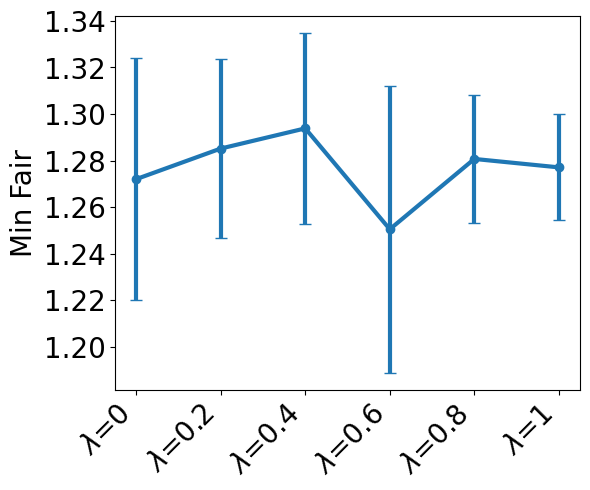

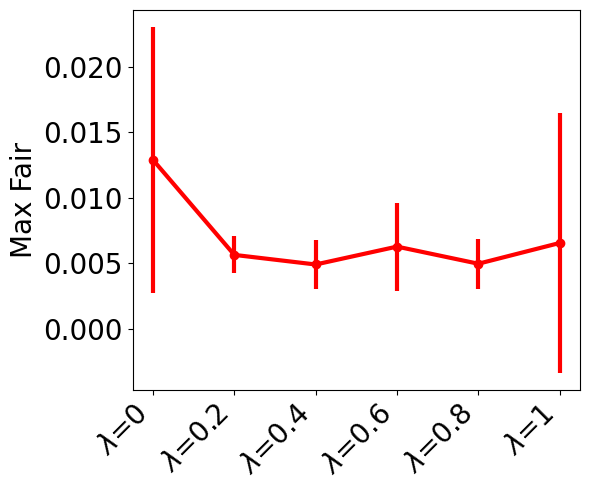

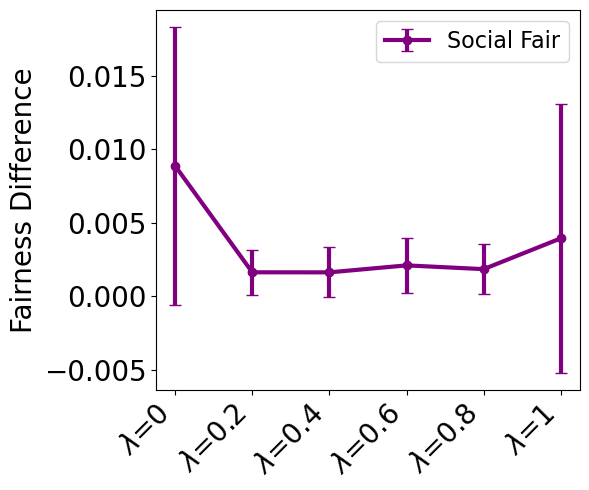

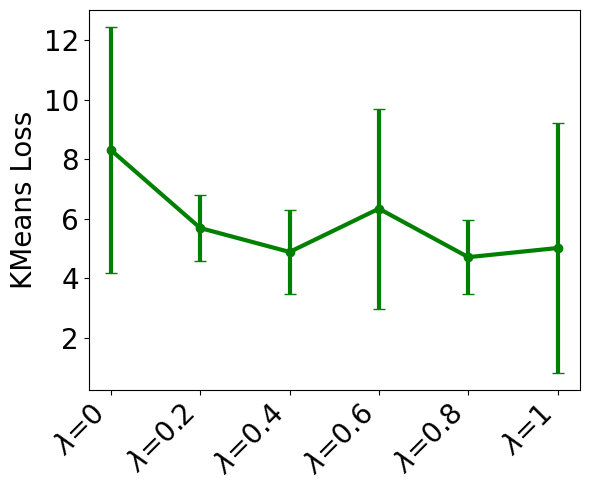

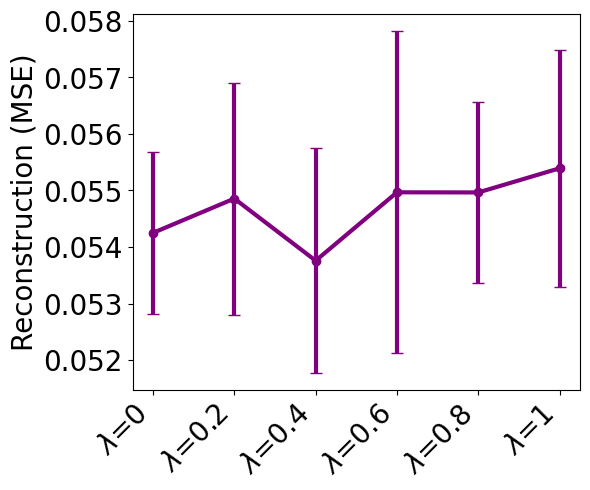

Plots saved in: ./plots


In [29]:
def plot_all_metrics_extended(min_fair_dict,
                              max_fair_dict,
                              social_fair_gap,
                              kmeans_costs_dict,
                              seperation_fair_gap,
                              rec_costs_dict=None,     # optional
                              cmp_costs_dict=None,     # optional
                              save_path="./plots"):
    
    """
    Plots mean ± std over seeds vs lambda in your exact style.
    Required: min_fair, fairness_gap, kmeans_costs dicts.
    Optional: reconstruction, compactness dicts (same structure).
    """
    def _to_numpy(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        if isinstance(x, (list, tuple)):
            if len(x) and isinstance(x[0], torch.Tensor):
                return np.stack([t.detach().cpu().numpy() for t in x])
            return np.asarray(x, dtype=float)
        return np.asarray(x, dtype=float)

    def _get_mean_std(metric_dict, lambda_list):
        means, stds = [], []
        for lam in lambda_list:
            arr = _to_numpy(metric_dict[lam])
            means.append(float(np.mean(arr)) if arr.size else 0.0)
            stds.append(float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0)
        return means, stds
    
    def lam_label(l):
        s=f"{l:.2f}".rstrip('0').rstrip('.')
        return r'$\lambda$='+s
    
    lambda_list = sorted(min_fair_dict.keys())
    all_lams = sorted(lambda_list)
    tick_pos   = np.arange(1, 1 + len(all_lams))
    tick_labels = [lam_label(l) for l in all_lams]

    # ----- Min Fair -----
    min_fair_mean, min_fair_std = _get_mean_std(min_fair_dict, lambda_list)
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, min_fair_mean, yerr=min_fair_std, fmt='-o', capsize=4, linewidth=3)
    plt.ylabel('Min Fair', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/min_fair_social.pdf", dpi=300)
    plt.show()

    # ---------- Plot 2: social term (max(LA,LB)) ----------
    max_fair_mean, max_fair_std = _get_mean_std(max_fair_dict, lambda_list)

    plt.figure(figsize=(6,5))
    plt.errorbar(tick_pos, max_fair_mean, yerr=max_fair_std,
                 marker='o', linewidth=3, color='red')
    plt.ylabel('Max Fair', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout(); 
    plt.savefig(f"{save_path}/max_fair_social.pdf", dpi=300); 
    plt.show()


    # ----- Fairness Gap -----
    social_gap_mean, social_gap_std = _get_mean_std(social_fair_gap, lambda_list)
    seperation_gap_mean, seperation_gap_std = _get_mean_std(seperation_fair_gap, lambda_list)

    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, social_gap_mean, yerr=social_gap_std, fmt='-o', capsize=4, color='purple', linewidth=3, label='Social Fair')
    plt.ylabel('Fairness Difference', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.legend(fontsize=16); 
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/fairness_gap_social.pdf", dpi=300)
    plt.show()

    # ----- KMeans Cost -----
    cost_mean, cost_std = _get_mean_std(kmeans_costs_dict, lambda_list)
    plt.figure(figsize=(6, 5))
    plt.errorbar(tick_pos, cost_mean, yerr=cost_std, fmt='-o', capsize=4, color='green', linewidth=3)
    plt.ylabel('KMeans Loss', fontsize=20)
    plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f"{save_path}/kmeans_cost_social.pdf", dpi=300)
    plt.show()

    
    # ----- Reconstruction (optional) -----
    if rec_costs_dict is not None:
        rec_mean, rec_std = _get_mean_std(rec_costs_dict, lambda_list)
        plt.figure(figsize=(6, 5))
        plt.errorbar(tick_pos, rec_mean, yerr=rec_std, fmt='-o', capsize=4, color='purple', linewidth=3)
        plt.ylabel('Reconstruction (MSE)', fontsize=20)
        plt.xticks(tick_pos, tick_labels, rotation=45, ha='right', fontsize=20)
        plt.yticks(fontsize=20)
        plt.tight_layout()
        plt.savefig(f"{save_path}/reconstruction_social.pdf", dpi=300)
        plt.show()

    print(f"Plots saved in: {save_path}")



# ===== Example usage with deep-run dicts =====
plot_all_metrics_extended(min_fair_dict,max_fair_dict,social_fair_gap, kmeans_costs,seperation_fair_gap,
                           rec_costs_dict=rec_costs, cmp_costs_dict=cmp_costs,
                           save_path="./plots")

